In [1]:
import numpy as np
import pandas as pd
import itertools
#from tqdm import tqdm
import matplotlib.pyplot as plt
#from pandas_datareader import data as web
plt.style.use("default")
import re
import requests
from bs4 import BeautifulSoup
# For reproducibility
np.random.seed(42)


In [2]:
import ftplib

ftp = ftplib.FTP("ftp2.interactivebrokers.com")
ftp.login(user="shortstock", passwd="")  # password is blank / anonymous

files = ftp.nlst()
print(files)

ftp.quit()


['australia.txt', 'australia.txt.md5', 'austria.txt', 'austria.txt.md5', 'belgium.txt', 'belgium.txt.md5', 'british.txt', 'british.txt.md5', 'canada.txt', 'canada.txt.md5', 'dutch.txt', 'dutch.txt.md5', 'france.txt', 'france.txt.md5', 'germany.txt', 'germany.txt.md5', 'hongkong.txt', 'hongkong.txt.md5', 'india.txt', 'india.txt.md5', 'italy.txt', 'italy.txt.md5', 'japan.txt', 'japan.txt.md5', 'mexico.txt', 'mexico.txt.md5', 'singapore.txt', 'singapore.txt.md5', 'spain.txt', 'spain.txt.md5', 'stockmargin_final_dtls.IB-AU.dat', 'stockmargin_final_dtls.IB-AU.dat.md5', 'stockmargin_final_dtls.IB-CAN.dat', 'stockmargin_final_dtls.IB-CAN.dat.md5', 'stockmargin_final_dtls.IB-HK.dat', 'stockmargin_final_dtls.IB-HK.dat.md5', 'stockmargin_final_dtls.IB-IN.dat', 'stockmargin_final_dtls.IB-IN.dat.md5', 'stockmargin_final_dtls.IB-JP.dat', 'stockmargin_final_dtls.IB-JP.dat.md5', 'stockmargin_final_dtls.IB-SG.dat', 'stockmargin_final_dtls.IB-SG.dat.md5', 'stockmargin_final_dtls.IB-UKL.dat', 'stockmarg

'221 Goodbye.'

In [3]:
import ftplib
import io

def fetch_ibkr_shortstock_file(filename="usa.txt") -> pd.DataFrame:
    ftp = ftplib.FTP("ftp2.interactivebrokers.com")
    ftp.login(user="shortstock", passwd="")

    buf = io.BytesIO()
    ftp.retrbinary(f"RETR {filename}", buf.write)
    ftp.quit()

    buf.seek(0)
    text = buf.getvalue().decode("utf-8", errors="ignore")
    lines = [ln for ln in text.splitlines() if ln.strip()]

    # Find the header line that starts with #SYM|
    header_idx = None
    for i, ln in enumerate(lines):
        if ln.startswith("#SYM|"):
            header_idx = i
            break
    if header_idx is None:
        raise ValueError("Could not find header line starting with '#SYM|'")

    header_line = lines[header_idx]
    data_lines = lines[header_idx + 1:]

    # Build column names from header
    header_cols = [c.strip().lstrip("#").lower() for c in header_line.split("|")]

    # Join data lines back to a CSV-like string
    data_str = "\n".join(data_lines)
    data_buf = io.StringIO(data_str)

    # Read data; allow Python engine for safety
    df = pd.read_csv(
        data_buf,
        sep="|",
        header=None,
        engine="python"
    )

    # Trim / align columns
    n_cols = min(len(header_cols), df.shape[1])
    df = df.iloc[:, :n_cols]
    df.columns = header_cols[:n_cols]

    # Drop any empty / unnamed trailing columns
    df = df.drop(columns=[c for c in df.columns if not c or str(c).startswith("unnamed")], errors="ignore")

    return df


In [4]:
short_df = fetch_ibkr_shortstock_file("usa.txt")
short_df.head()


,sym,cur,name,con,isin,rebaterate,feerate,available,figi
0,A,USD,AGILENT TECHNOLOGIES INC,1715006.0,XXXXXXXU1016,3.3518,0.2782,4800000,BBG000C2V3D6
1,AA,USD,ALCOA CORP,251962528.0,XXXXXXX21065,3.3800,0.2500,5600000,BBG00B3T3HD3
2,AAA,USD,ALTERNATIVE ACCESS FIRST PRI,591368776.0,XXXXXXXX6105,-0.4369,4.0669,6000,BBG01B0JRCS6
3,AAAA,USD,AMPLIUS AGGRESSIVE A ALL ETF,799151665.0,XXXXXXXQ6897,-80.1799,83.8099,65000,BBG01W275XX6
4,AAAU,USD,GOLDMAN SACHS PHYSICAL GOLD,458886642.0,XXXXXXXK1034,3.1279,0.5021,200000,BBG00LPXX872


In [5]:
short_df.columns

Index(['sym', 'cur', 'name', 'con', 'isin', 'rebaterate', 'feerate',
       'available', 'figi'],
      dtype='object')

In [6]:
import numpy as np

def build_ibkr_short_maps(
    tickers,
    filename="usa.txt",
    default_borrow=0.05,   # 5% if not found
    default_rebate=0.0
):
    """
    Use IBKR's public shortstock FTP file to build:
      - net borrow rate map (fee - rebate)
      - rebate rate map
      - available-shares map

    All rates returned as decimals (e.g. 0.12 = 12% per year).
    """
    tickers = [t.upper() for t in tickers]

    short_df = fetch_ibkr_shortstock_file(filename)

    # Clean / normalize columns
    short_df["sym"] = short_df["sym"].astype(str).str.upper().str.strip()

    # Some files are in percent (e.g. 3.6300 means 3.63%)
    # Convert to decimals
    short_df["rebate_annual"] = pd.to_numeric(short_df["rebaterate"], errors="coerce") / 100.0
    short_df["fee_annual"]    = pd.to_numeric(short_df["feerate"],    errors="coerce") / 100.0
    short_df["available_int"] = pd.to_numeric(short_df["available"],  errors="coerce")

    # Net borrow cost to you ≈ fee - rebate.
    # If this goes negative (i.e. you actually earn carry),
    # you can either keep it or clip at 0. I'll clip at 0 to be conservative.
    short_df["net_borrow_annual"] = short_df["fee_annual"] - short_df["rebate_annual"]
    short_df["net_borrow_annual"] = short_df["net_borrow_annual"].clip(lower=0)

    # Filter only the symbols we care about
    mask = short_df["sym"].isin(tickers)
    sub = short_df.copy()

    borrow_map = {}
    rebate_map = {}
    available_map = {}

    for _, row in sub.iterrows():
        sym = row["sym"]
        if pd.notna(row["net_borrow_annual"]):
            borrow_map[sym] = float(row["net_borrow_annual"])
        if pd.notna(row["rebate_annual"]):
            rebate_map[sym] = float(row["rebate_annual"])
        if pd.notna(row["available_int"]):
            available_map[sym] = int(row["available_int"])

    # Defaults for anything missing
    borrow_map["default"] = default_borrow
    rebate_map["default"] = default_rebate

    return borrow_map, rebate_map, available_map


In [7]:
import yfinance as yf
import pandas as pd
import numpy as np

def get_total_return_series(ticker, start=None, end=None):
    """
    Long-only total return price series:
    TR_t = TR_{t-1} * (Close_t + Div_t) / Close_{t-1}
    """
    t = yf.Ticker(ticker)

    df = t.history(period='max', auto_adjust=False, actions=True)

    if df.empty or "Close" not in df.columns:
        print(f"[WARN] No Yahoo data for {ticker}")
        return pd.Series(dtype=float)

    # Restrict dates if provided
    if start is not None:
        df = df[df.index >= pd.to_datetime(start)]
    if end is not None:
        df = df[df.index <= pd.to_datetime(end)]

    if df.empty:
        print(f"[WARN] No data in range for {ticker}")
        return pd.Series(dtype=float)

    close = df["Close"]
    divs = df.get("Dividends", pd.Series(0.0, index=df.index))
    divs = divs.reindex(close.index, fill_value=0.0)
    rel = (close + divs) / close.shift(1)
    rel.iloc[0] = 1.0

    tr_price = close.iloc[0] * rel.cumprod()
    tr_price.name = ticker + "_TR"
    return tr_price


In [8]:
def compute_leg_stats(tr_price: pd.Series, trading_days: int = 252):
    """
    Given a total-return price series (long), compute stats and daily returns.
    Returns:
        stats: dict with cagr, vol_annual, etc.
        ret:   daily simple returns (aligned with tr_price.index[1:])
    """
    tr_price = tr_price.dropna()
    if len(tr_price) < 3:
        return None, pd.Series(dtype=float)

    ret = tr_price.pct_change().dropna()
    T = len(ret)

    cumulative = (1 + ret).prod()
    cagr = cumulative ** (trading_days / T) - 1.0
    vol_annual = ret.std() * np.sqrt(trading_days)

    stats = {
        "cagr": cagr,
        "vol_annual": vol_annual,
        "n_obs": T,
    }
    return stats, ret


def portfolio_returns(long_ret: pd.Series,
                      etf_ret: pd.Series,
                      w_long: float,
                      w_short: float,
                      borrow_annual: float = 0.0,
                      trading_days: int = 252) -> pd.Series:
    """
    Combine long underlying + short ETF (via negative w_short).
    long_ret, etf_ret: daily simple returns of LONG legs (total return)
    w_long:  weight on underlying
    w_short: weight on ETF (negative for short)
    borrow_annual: annualized borrow cost for the ETF (decimal, e.g. 0.37)
    """
    borrow_daily = borrow_annual / trading_days

    df = pd.concat(
        [long_ret.rename("long"), etf_ret.rename("etf")],
        axis=1
    ).dropna()

    if df.empty:
        return pd.Series(dtype=float)

    # Portfolio return including borrow drag
    port_ret = (
        w_long * df["long"] +
        w_short * df["etf"] -
        abs(w_short) * borrow_daily
    )
    port_ret.name = "port_ret"
    return port_ret



def worst_rolling_window(ret_series, window=60):
    """
    Numerically stable worst rolling-window cumulative return.
    ret_series: daily returns in decimal form (0.01 = 1%).
    
    Returns:
        worst_cum_ret: float (e.g. -0.35 for -35%)
        worst_end_date: index label corresponding to the *end* of that window
    """
    # Keep the original index intact
    r = pd.Series(ret_series)

    # If too short, bail
    if r.dropna().shape[0] < window:
        return np.nan, None

    # Safety: if returns look like percentages (5 = 500%), scale them
    # We DON'T want to change the index, only the values.
    if r.abs().max() > 2:  # heuristic threshold
        r = r / 100.0

    # Use log(1+r) for stability
    log_g = np.log1p(r)  # this will propagate NaNs
    # rolling sum of logs, aligning the result to the *right* edge (default)
    roll_log = log_g.rolling(window=window, min_periods=window).sum()

    # Convert back from log-space: exp(sum log) - 1
    roll_cum = np.expm1(roll_log)

    # Drop NaNs (these correspond to windows that weren't full)
    roll_cum_valid = roll_cum.dropna()
    if roll_cum_valid.empty:
        return np.nan, None

    worst = roll_cum_valid.min()
    worst_end_date = roll_cum_valid.idxmin()  # this is the *end* of the window

    return float(worst), worst_end_date


def margin_call_probability(port_ret, margin_level=0.25):
    """
    Simple margin-call metric: equity starts at 1.0,
    margin call if equity < margin_level at any point.
    Returns (probability_over_days, first_call_date).
    """
    equity = (1 + port_ret).cumprod()
    calls = equity < margin_level
    if not calls.any():
        return 0.0, None
    prob = calls.mean()
    first_call_date = equity.index[calls.argmax()]
    return float(prob), first_call_date



In [9]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.linear_model import LinearRegression

def compute_beta(etf: str, underlying: str, *, start="2024-01-01", end=None, use_adj=True):
    etf = etf.upper().strip()
    underlying = underlying.upper().strip()

    px = yf.download([etf, underlying], start=start, end=end, auto_adjust=False, progress=False)

    # yfinance returns either a MultiIndex column or single columns depending on tickers
    col = "Adj Close" if use_adj else "Close"
    if isinstance(px.columns, pd.MultiIndex):
        if col not in px.columns.get_level_values(0):
            raise ValueError(f"Price column '{col}' not found. Available: {sorted(set(px.columns.get_level_values(0)))}")
        prices = px[col].copy()
    else:
        # single ticker case (shouldn't happen here but be defensive)
        prices = px[[col]].copy()
        prices.columns = [etf]

    # Ensure both tickers exist
    missing = [t for t in [etf, underlying] if t not in prices.columns]
    if missing:
        raise ValueError(f"Missing price series for: {missing}. Columns present: {prices.columns.tolist()}")

    # Compute returns
    ret = prices.pct_change()

    # IMPORTANT: only drop rows where either is missing (pairwise), not entire frame arbitrarily
    pair = ret[[etf, underlying]].dropna(how="any")

    # Diagnostics
    if pair.empty:
        # give helpful debug info
        info = {
            "etf_non_na_prices": int(prices[etf].notna().sum()),
            "und_non_na_prices": int(prices[underlying].notna().sum()),
            "overlap_non_na_rows": int(ret[[etf, underlying]].dropna(how="any").shape[0]),
            "price_date_range": (str(prices.index.min().date()), str(prices.index.max().date())) if len(prices.index) else None,
        }
        raise ValueError(
            f"No overlapping return samples for {etf} vs {underlying}. "
            f"Likely ETF is new or missing data. Diagnostics: {info}"
        )

    X = pair[[underlying]].values  # shape (n,1)
    y = pair[[etf]].values         # shape (n,1)

    model = LinearRegression().fit(X, y)
    beta = float(model.coef_[0][0])
    alpha = float(model.intercept_[0])

    return beta, alpha, pair

# Example
beta, alpha, ret = compute_beta("PLTY", "PLTR", start="2025-01-01")
print("n samples:", len(ret))
print("beta:", beta, "alpha:", alpha)

beta, alpha, ret = compute_beta("GOOY", "GOOGL")
print("Beta (GOOY vs GOOGL):", beta)
print("Alpha:", alpha)

beta, alpha, ret = compute_beta("MSTW", "MSTR")
print("Beta (MSTW vs MSTR):", beta)
print("Alpha:", alpha)


n samples: 268
beta: 0.8085292464945896 alpha: -0.0006210492246829765
Beta (GOOY vs GOOGL): 0.7450905705975982
Alpha: -0.00013284235710203022
Beta (MSTW vs MSTR): 1.1804261467805213
Alpha: -0.0006864844727620632


In [10]:
def portfolio_returns_twolegs_daily_rebalanced(
    ret_a: pd.Series,
    ret_b: pd.Series,
    w_a: float,
    w_b: float,
    borrow_a_annual: float = 0.0,
    borrow_b_annual: float = 0.0,
    trading_days: int = 252,
    initial_equity: float = 1.0,
) -> tuple[pd.Series, pd.Series]:
    """
    Explicit daily rebalance:
      - Start of day: set notionals = w_i * equity
      - Apply that day's returns to those notionals
      - Charge borrow on short notionals
      - Update equity
      - Next day: rebalance again

    Returns:
      port_ret: daily equity-to-equity returns
      equity:   daily equity curve
    """
    df = pd.concat([ret_a.rename("a"), ret_b.rename("b")], axis=1).dropna()
    if df.empty:
        return pd.Series(dtype=float), pd.Series(dtype=float)

    borrow_a_daily = borrow_a_annual / trading_days
    borrow_b_daily = borrow_b_annual / trading_days

    equity = float(initial_equity)
    port_rets = []
    eq_curve = []

    for _, r in df.iterrows():
        notional_a = w_a * equity
        notional_b = w_b * equity

        pnl = notional_a * r["a"] + notional_b * r["b"]

        borrow_cost = 0.0
        if w_a < 0:
            borrow_cost += abs(notional_a) * borrow_a_daily
        if w_b < 0:
            borrow_cost += abs(notional_b) * borrow_b_daily

        equity_next = equity + pnl - borrow_cost
        port_ret = equity_next / equity - 1.0

        port_rets.append(port_ret)
        eq_curve.append(equity_next)
        equity = equity_next

    port_ret_s = pd.Series(port_rets, index=df.index, name="port_ret")
    equity_s   = pd.Series(eq_curve, index=df.index, name="equity")
    return port_ret_s, equity_s


In [11]:

# ============================================================
# Short-vs-Short Levered ETF Pair Research (2x and 3x)
# ============================================================
def portfolio_returns_twolegs(
    ret_a: pd.Series,
    ret_b: pd.Series,
    w_a: float,
    w_b: float,
    borrow_a_annual: float = 0.0,
    borrow_b_annual: float = 0.0,
    trading_days: int = 252,
) -> pd.Series:
    """
    Generic 2-leg portfolio return series.

    ret_a, ret_b: daily simple returns of LONG total-return price series
    w_a, w_b: portfolio weights (use negative for shorts)
    borrow_*_annual: annualized borrow cost applied ONLY when the corresponding weight is negative
    """
    df = pd.concat([ret_a.rename("a"), ret_b.rename("b")], axis=1).dropna()
    if df.empty:
        return pd.Series(dtype=float)

    borrow_a_daily = (borrow_a_annual / trading_days) if w_a < 0 else 0.0
    borrow_b_daily = (borrow_b_annual / trading_days) if w_b < 0 else 0.0

    port = (
        w_a * df["a"] +
        w_b * df["b"] -
        abs(w_a) * borrow_a_daily -
        abs(w_b) * borrow_b_daily
    )
    return port


def simulate_two_leg_monte_carlo(
    ret_a: pd.Series,
    ret_b: pd.Series,
    w_a: float,
    w_b: float,
    borrow_a_annual: float,
    borrow_b_annual: float,
    horizon_days: int = 252*5,
    n_sims: int = 1000,
    random_state: int | None = None,
    trading_days: int = 252,
    half_life_days: int | None = None,
):
    """
    Monte Carlo for a 2-leg portfolio where either or both legs can be short.

    Borrow drag is applied only to legs with negative weight.
    """
    rng = np.random.default_rng(random_state)

    ret_mat = pd.concat([ret_a.rename("a"), ret_b.rename("b")], axis=1).dropna()
    if ret_mat.shape[0] < 10:
        return None

    if half_life_days is None:
        mu = ret_mat.mean().values
        cov = ret_mat.cov().values
    else:
        mu = ret_mat.ewm(halflife=half_life_days, adjust=False).mean().iloc[-1].values
        ew_cov = ret_mat.ewm(halflife=half_life_days, adjust=False).cov()
        cov = ew_cov.xs(ew_cov.index.get_level_values(0).max(), level=0).values

    borrow_a_daily = (borrow_a_annual / trading_days) if w_a < 0 else 0.0
    borrow_b_daily = (borrow_b_annual / trading_days) if w_b < 0 else 0.0

    sim_cagrs, sim_dds = [], []
    for _ in range(n_sims):
        sim_daily = rng.multivariate_normal(mu, cov, size=horizon_days)
        sim_a = sim_daily[:, 0]
        sim_b = sim_daily[:, 1]

        sim_port = (
            w_a * sim_a +
            w_b * sim_b -
            abs(w_a) * borrow_a_daily -
            abs(w_b) * borrow_b_daily
        )

        T = len(sim_port)
        cumulative = (1 + sim_port).prod()
        cagr = cumulative ** (trading_days / T) - 1.0

        cum_curve = (1 + sim_port).cumprod()
        peak = np.maximum.accumulate(cum_curve)
        dd = (cum_curve / peak - 1.0).min()

        sim_cagrs.append(cagr)
        sim_dds.append(dd)

    sim_cagrs = np.array(sim_cagrs)
    sim_dds   = np.array(sim_dds)

    return {
        "mc_cagr_p50": np.percentile(sim_cagrs, 50),
        "mc_cagr_p10": np.percentile(sim_cagrs, 10),
        "mc_cagr_p90": np.percentile(sim_cagrs, 90),
        "mc_dd_p50":   np.percentile(sim_dds, 50),
        "mc_dd_p10":   np.percentile(sim_dds, 10),
        "mc_dd_p90":   np.percentile(sim_dds, 90),
    }


def analyze_short_short_pairs_with_mc(
    pairs_df: pd.DataFrame,
    start=None,
    end=None,
    w_a: float = -0.5,
    w_b: float = -0.5,
    margin_level: float = 0.25,
    horizon_days: int = 252*5,
    n_sims: int = 1000,
    borrow_map: dict | None = None,
    default_borrow: float = 0.05,
    trading_days: int = 252,
    half_life_days: int | None = None,
):
    """
    pairs_df columns: ["LegA","LegB","Leverage","Group"] (Group optional)

    Interprets weights as dollar weights on *long* returns; use negatives for shorts.
    For a symmetric decay trade (e.g., short TQQQ + short SQQQ), defaults to -0.5 / -0.5.
    """
    results = []

    for _, row in pairs_df.iterrows():
        
        a = row["LegA"]
        b = row["LegB"]
        lev = float(row.get("Leverage", np.nan))
        grp = row.get("Group", "")

        print(f"\nProcessing SHORT/SHORT pair: {a} vs {b} (lev={lev}, group={grp})")

        prices_a = get_total_return_series(a, start=start, end=end)
        prices_b = get_total_return_series(b, start=start, end=end)

        if prices_a.empty or prices_b.empty:
            print(" → SKIPPED: missing price data")
            continue

        stats_a, ret_a = compute_leg_stats(prices_a, trading_days=trading_days)
        stats_b, ret_b = compute_leg_stats(prices_b, trading_days=trading_days)

        if stats_a is None or stats_b is None:
            print(" → SKIPPED: insufficient returns")
            continue

        # Borrow (each leg)
        if borrow_map is not None:
            borrow_a = borrow_map.get(a, borrow_map.get("default", default_borrow))
            borrow_b = borrow_map.get(b, borrow_map.get("default", default_borrow))
        else:
            borrow_a = default_borrow
            borrow_b = default_borrow

        port_ret, equity_curve = portfolio_returns_twolegs_daily_rebalanced(
            ret_a, ret_b,
            w_a=w_a, w_b=w_b,
            borrow_a_annual=borrow_a,
            borrow_b_annual=borrow_b,
            trading_days=trading_days,
            initial_equity=1.0,
        )

        if port_ret.empty:
            print(" → SKIPPED: empty portfolio series")
            continue

        # Hist stats (now based on equity curve)
        T = len(equity_curve)
        cumulative = float(equity_curve.iloc[-1])   # equity starts at 1.0
        cagr_port = cumulative ** (trading_days / T) - 1.0
        vol_port  = port_ret.std() * np.sqrt(trading_days)

        # (keep your existing margin call call for now; see note below)
        mc_prob_hist, mc_first_hist = margin_call_probability(port_ret, margin_level=margin_level)

        # MC
        mc_stats = simulate_two_leg_monte_carlo(
            ret_a=ret_a,
            ret_b=ret_b,
            w_a=w_a,
            w_b=w_b,
            borrow_a_annual=borrow_a,
            borrow_b_annual=borrow_b,
            horizon_days=horizon_days,
            n_sims=n_sims,
            random_state=42,
            trading_days=trading_days,
            half_life_days=half_life_days,
        )

        if mc_stats is None:
            print(" → SKIPPED: MC stats unavailable")
            continue

        results.append({
            "LegA": a,
            "LegB": b,
            "Leverage": lev,
            "Group": grp,
            "w_a": w_a,
            "w_b": w_b,
            "borrow_a": borrow_a,
            "borrow_b": borrow_b,
            "cagr_a": stats_a["cagr"],
            "cagr_b": stats_b["cagr"],
            "vol_a":  stats_a["vol_annual"],
            "vol_b":  stats_b["vol_annual"],
            "cagr_port_hist": cagr_port,
            "vol_port_hist":  vol_port,
            "mc_prob_hist":   mc_prob_hist,
            "mc_first_hist":  mc_first_hist,
            **mc_stats,
        })

    return pd.DataFrame(results)


In [12]:

# --- Simple starter lists of 2x and 3x levered "bull vs bear" pairs ---
# Notes:
# - These are meant to be *same-underlying* leveraged opposites.
# - For the "short/short decay" trade, we short BOTH legs (defaults: -0.5 / -0.5).
pairs_2x = [
    ("SSO",  "SDS",  2, "SPX"),     # S&P 500
    ("QLD",  "QID",  2, "NDX"),     # Nasdaq-100
    ("DDM",  "DXD",  2, "DJIA"),    # Dow
    ("UWM",  "TWM",  2, "RUT"),     # Russell 2000
    ("UCO",  "SCO",  2, "WTI"),     # Crude oil (path-dependent; can be noisy)
    ("MSTU", "MSTZ", 2, "MSTR"),
    ("NVDX", "NVDQ", 2, "NVDA"),
    ("BTCL", "BTCZ", 2, "BTC"),
    ("ETU", "ETHD", 2, "ETH"),
    ("CCUP", "CRCD", 2, "CRCL"),
    ("CRWU", "CORD", 2, "CRWV"),
    ("TSLR", "TSLQ", 2, "TSLA"),
    ("AGQ", "ZSL", 2, "SLV") # Lower borrow
]

pairs_3x = [
    ("TQQQ", "SQQQ", 3, "NDX"),
    ("SPXL", "SPXS", 3, "SPX"),
    ("TNA",  "TZA",  3, "RUT"),
    ("SOXL", "SOXS", 3, "SOX"),
    ("FAS",  "FAZ",  3, "FIN"),
    ("LABU", "LABD", 3, "BIOTECH"),
    ("TECL", "TECS", 3, "TECH"),
    ("UDOW", "SDOW", 3, "DJIA"),
    ("NUGT", "DUST", 3, "GDX"),
]

pairs_shortshort = pd.DataFrame(pairs_2x + pairs_3x, columns=["LegA","LegB","Leverage","Group"])
pairs_shortshort


,LegA,LegB,Leverage,Group
0,SSO,SDS,2,SPX
1,QLD,QID,2,NDX
2,DDM,DXD,2,DJIA
3,UWM,TWM,2,RUT
4,UCO,SCO,2,WTI
5,MSTU,MSTZ,2,MSTR
6,NVDX,NVDQ,2,NVDA
7,BTCL,BTCZ,2,BTC
8,ETU,ETHD,2,ETH
9,CCUP,CRCD,2,CRCL


In [14]:
# adjust column names if yours differ
borrow_map_pairs, rebate_map_pairs, available_map_pairs = build_ibkr_short_maps(
    tickers=[],
    filename="usa.txt",
    default_borrow=0.05,
    default_rebate=0.0
)

borrow_map_pairs


{'A': 0.0,
 'AA': 0.0,
 'AAA': 0.045038,
 'AAAA': 1.639898,
 'AAAU': 0.0,
 'AABB': 0.007549999999999999,
 'AABVF': 0.0,
 'AACAY': 0.0,
 'AACB': 0.0,
 'AACBU': 0.0,
 'AACG': 0.050452,
 'AACS': 0.0,
 'AACTF': 0.087318,
 'AADR': 0.054692000000000005,
 'AAEQ': 0.0,
 'AAGAF': 0.30537800000000004,
 'AAGC': 0.23043799999999998,
 'AAGFF': 0.057584,
 'AAGIY': 0.0,
 'AAGR': 0.16151,
 'AAIRF': 0.100278,
 'AAL': 0.0,
 'AALG': 0.23024,
 'AAM': 0.86774,
 'AAME': 0.028802000000000005,
 'AAMI': 0.0,
 'AAMMF': 0.10978399999999999,
 'AAMTF': 0.0,
 'AAMUQ': 0.0,
 'AAOI': 0.0,
 'AAON': 0.0,
 'AAP': 0.0,
 'AAPB': 0.061278,
 'AAPD': 0.03897199999999999,
 'AAPG': 0.7765,
 'AAPI': 0.0,
 'AAPJ': 0.0,
 'AAPL': 0.0,
 'AAPR': 0.017977000000000003,
 'AAPT': 0.0,
 'AAPU': 0.055742,
 'AAPW': 0.292212,
 'AAPX': 0.11307400000000001,
 'AAPY': 0.043378,
 'AARD': 0.014630000000000002,
 'AASP': 0.0,
 'AAT': 0.0,
 'AATC': 0.054812,
 'AATV': 0.0,
 'AAUAF': 0.0,
 'AAUC': 0.003347999999999997,
 'AAUGF': 0.06728,
 'AAUS': 0.04

In [15]:

# --- Run the short/short analysis ---
results_shortshort_mc = analyze_short_short_pairs_with_mc(
    pairs_shortshort,
    start=None,
    end=None,
    w_a=-0.5,      # short $0.50 of LegA
    w_b=-0.5,      # short $0.50 of LegB  -> gross short = 1.0
    margin_level=0.25,
    horizon_days=252*5,
    n_sims=500,
    borrow_map=borrow_map_pairs,
    default_borrow=borrow_map_pairs.get("default", 0.05),
    half_life_days=252,   # optional: more weight on recent history
)



Processing SHORT/SHORT pair: SSO vs SDS (lev=2.0, group=SPX)

Processing SHORT/SHORT pair: QLD vs QID (lev=2.0, group=NDX)

Processing SHORT/SHORT pair: DDM vs DXD (lev=2.0, group=DJIA)

Processing SHORT/SHORT pair: UWM vs TWM (lev=2.0, group=RUT)

Processing SHORT/SHORT pair: UCO vs SCO (lev=2.0, group=WTI)

Processing SHORT/SHORT pair: MSTU vs MSTZ (lev=2.0, group=MSTR)

Processing SHORT/SHORT pair: NVDX vs NVDQ (lev=2.0, group=NVDA)

Processing SHORT/SHORT pair: BTCL vs BTCZ (lev=2.0, group=BTC)

Processing SHORT/SHORT pair: ETU vs ETHD (lev=2.0, group=ETH)

Processing SHORT/SHORT pair: CCUP vs CRCD (lev=2.0, group=CRCL)

Processing SHORT/SHORT pair: CRWU vs CORD (lev=2.0, group=CRWV)

Processing SHORT/SHORT pair: TSLR vs TSLQ (lev=2.0, group=TSLA)

Processing SHORT/SHORT pair: AGQ vs ZSL (lev=2.0, group=SLV)

Processing SHORT/SHORT pair: TQQQ vs SQQQ (lev=3.0, group=NDX)

Processing SHORT/SHORT pair: SPXL vs SPXS (lev=3.0, group=SPX)

Processing SHORT/SHORT pair: TNA vs TZA (lev=3

In [16]:
results_shortshort_mc.sort_values("mc_cagr_p50", ascending=False)

,LegA,LegB,Leverage,Group,w_a,w_b,borrow_a,borrow_b,cagr_a,cagr_b,...,cagr_port_hist,vol_port_hist,mc_prob_hist,mc_first_hist,mc_cagr_p50,mc_cagr_p10,mc_cagr_p90,mc_dd_p50,mc_dd_p10,mc_dd_p90
7,BTCL,BTCZ,2.0,BTC,-0.5,-0.5,0.029434,0.442858,0.086927,-0.681315,...,-0.160088,0.030870,0.000000,NaT,0.056819,0.038825,0.077599,-0.033427,-0.048949,-0.024797
12,AGQ,ZSL,2.0,SLV,-0.5,-0.5,0.000000,0.044112,0.127399,-0.445004,...,0.026187,0.035577,0.000000,NaT,0.016276,-0.006626,0.040602,-0.072876,-0.119584,-0.048751
16,SOXL,SOXS,3.0,SOX,-0.5,-0.5,0.000000,0.050000,0.341702,-0.682883,...,-0.001211,0.034908,0.000000,NaT,-0.022492,-0.037443,-0.007187,-0.130101,-0.189308,-0.076478
1,QLD,QID,2.0,NDX,-0.5,-0.5,0.000000,0.002488,0.244461,-0.346131,...,0.000857,0.014095,0.000000,NaT,-0.026447,-0.028963,-0.023832,-0.125782,-0.136803,-0.113776
0,SSO,SDS,2.0,SPX,-0.5,-0.5,0.000000,0.010876,0.152022,-0.250138,...,-0.007537,0.014003,0.000000,NaT,-0.033365,-0.035715,-0.030876,-0.156297,-0.166422,-0.145147
2,DDM,DXD,2.0,DJIA,-0.5,-0.5,0.000000,0.029704,0.139695,-0.232841,...,-0.015094,0.017156,0.000000,NaT,-0.041245,-0.044289,-0.037972,-0.190240,-0.202915,-0.176078
13,TQQQ,SQQQ,3.0,NDX,-0.5,-0.5,0.000000,0.050000,0.417172,-0.525465,...,-0.015426,0.012488,0.000000,NaT,-0.041502,-0.045478,-0.037360,-0.191699,-0.207925,-0.173497
20,UDOW,SDOW,3.0,DJIA,-0.5,-0.5,0.018080,0.024452,0.259603,-0.381912,...,-0.017477,0.015041,0.000000,NaT,-0.043834,-0.047193,-0.040412,-0.201312,-0.214846,-0.186532
14,SPXL,SPXS,3.0,SPX,-0.5,-0.5,0.000000,0.050000,0.277767,-0.453389,...,-0.013858,0.014240,0.000000,NaT,-0.049635,-0.054989,-0.044198,-0.225784,-0.246834,-0.202929
9,CCUP,CRCD,2.0,CRCL,-0.5,-0.5,0.292738,1.011170,-0.990617,4.929488,...,-0.441902,0.061556,0.000000,NaT,-0.051559,-0.080078,-0.025243,-0.264197,-0.360224,-0.173047


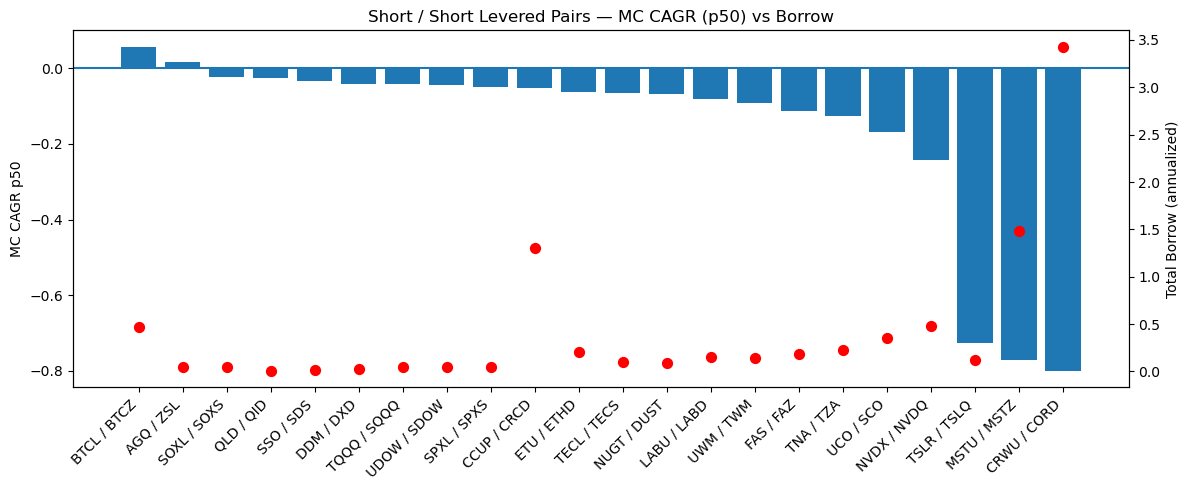

In [17]:
import matplotlib.pyplot as plt
import numpy as np

df = results_shortshort_mc.copy()

# Build labels and total borrow
df["pair"] = df["LegA"] + " / " + df["LegB"]
df["borrow_total"] = df["borrow_a"] + df["borrow_b"]

# Sort: highest CAGR → lowest
df = df.sort_values("mc_cagr_p50", ascending=False).reset_index(drop=True)

x = np.arange(len(df))

fig, ax1 = plt.subplots(figsize=(12, 5))

# --- Left axis: MC CAGR ---
ax1.bar(x, df["mc_cagr_p50"])
ax1.axhline(0)
ax1.set_ylabel("MC CAGR p50")
ax1.set_xticks(x)
ax1.set_xticklabels(df["pair"], rotation=45, ha="right")

# --- Right axis: Borrow (points only, red) ---
ax2 = ax1.twinx()
ax2.scatter(
    x,
    df["borrow_total"],
    color="red",
    s=50,
    zorder=3
)
ax2.set_ylabel("Total Borrow (annualized)")

plt.title("Short / Short Levered Pairs — MC CAGR (p50) vs Borrow")
fig.tight_layout()
plt.show()


In [55]:
benchmark_map = {
    "SPX":   "SPY",   # or IVV
    "NDX":   "QQQ",
    "DJIA":  "DIA",
    "RUT":   "IWM",
    "SOX":   "SOXX",  # or SMH
    "FIN":   "XLF",
    "BIOTECH":"XBI",  # or IBB
    "TECH":  "XLK",
    "WTI":   "USO",   # not perfect; futures roll matters
    "TSLA":  "TSLA",
    "MSTR":  "MSTR",
    "NVDA":  "NVDA",
    "BTC":   "IBIT",  # or FBTC; pick one you can source reliably
    "ETH":   "ETHA",  # or similar spot ETH ETF if available in your data source
    "CRCL":  "CRCL",
    "CRWV":  "CRWV",
    "GDX": "GDX",
    "SLV": "SLV"
}


In [19]:
def build_levered_vs_benchmark_pairs_short_short(
    pairs_shortshort: pd.DataFrame,
    benchmark_map: dict,
    base_short: float = -0.5,
    normalize_gross: bool = True,
) -> pd.DataFrame:
    """
    Builds SHORT vs SHORT trades vs the benchmark ETF, but ONLY for the inverse (bear) levered ETFs.
    (i.e., excludes the 2x/3x LONG levered ETFs entirely)

    For each row (Bull, Bear, Leverage L, Group -> benchmark):
      - Short Bear vs Short Benchmark (size benchmark by L)

    Sizing:
      If normalize_gross=True:
        w_lev = -1/(1+L), w_bench = -L/(1+L)   (gross short = 1)
      Else:
        w_lev = base_short, w_bench = base_short * L
    """
    rows = []

    for _, r in pairs_shortshort.iterrows():
        bear = r["LegB"]              # inverse levered ETF
        L    = float(r["Leverage"])
        grp  = r["Group"]

        bench = benchmark_map.get(grp)
        if bench is None:
            continue

        if normalize_gross:
            w_lev   = -1.0 / (1.0 + L)
            w_bench = -L   / (1.0 + L)
        else:
            w_lev   = float(base_short)
            w_bench = float(base_short) * L

        rows.append({
            "LegA": bear,
            "LegB": bench,
            "Leverage": L,
            "Group": grp,
            "w_a": w_lev,
            "w_b": w_bench,
            "Case": "ShortBear_ShortBench"
        })

    return pd.DataFrame(rows)


In [20]:
def analyze_short_short_pairs_with_mc(
    pairs_df: pd.DataFrame,
    start=None,
    end=None,
    w_a: float = -0.5,
    w_b: float = -0.5,
    margin_level: float = 0.25,
    horizon_days: int = 252*5,
    n_sims: int = 1000,
    borrow_map: dict | None = None,
    default_borrow: float = 0.05,
    trading_days: int = 252,
    half_life_days: int | None = None,
):
    """
    Same as the original analyzer, but:
      - reads optional per-row weights w_a / w_b safely
      - does NOT mutate the function arguments across rows
    """
    results = []

    for _, row in pairs_df.iterrows():
        # --- Read weights PER ROW (do not overwrite w_a / w_b) ---
        w_a_eff = float(row["w_a"]) if ("w_a" in row and pd.notna(row["w_a"])) else float(w_a)
        w_b_eff = float(row["w_b"]) if ("w_b" in row and pd.notna(row["w_b"])) else float(w_b)

        a = row["LegA"]
        b = row["LegB"]
        lev = float(row.get("Leverage", np.nan))
        grp = row.get("Group", "")

        print(f"\nProcessing SHORT/SHORT pair: {a} vs {b} (lev={lev}, group={grp}, w=({w_a_eff},{w_b_eff}))")

        prices_a = get_total_return_series(a, start=start, end=end)
        prices_b = get_total_return_series(b, start=start, end=end)

        if prices_a.empty or prices_b.empty:
            print(" → SKIPPED: missing price data")
            continue

        stats_a, ret_a = compute_leg_stats(prices_a, trading_days=trading_days)
        stats_b, ret_b = compute_leg_stats(prices_b, trading_days=trading_days)

        if stats_a is None or stats_b is None:
            print(" → SKIPPED: insufficient returns")
            continue

        # Borrow (each leg)
        if borrow_map is not None:
            borrow_a = borrow_map.get(a, borrow_map.get("default", default_borrow))
            borrow_b = borrow_map.get(b, borrow_map.get("default", default_borrow))
        else:
            borrow_a = default_borrow
            borrow_b = default_borrow

        # Historical path (daily rebalanced equity engine)
        port_ret, equity_curve = portfolio_returns_twolegs_daily_rebalanced(
            ret_a, ret_b,
            w_a=w_a_eff, w_b=w_b_eff,
            borrow_a_annual=borrow_a,
            borrow_b_annual=borrow_b,
            trading_days=trading_days,
            initial_equity=1.0,
        )

        if port_ret.empty:
            print(" → SKIPPED: empty portfolio series")
            continue

        # Hist stats (based on equity curve)
        T = len(equity_curve)
        cumulative = float(equity_curve.iloc[-1])  # equity starts at 1.0
        cagr_port = cumulative ** (trading_days / T) - 1.0
        vol_port  = port_ret.std() * np.sqrt(trading_days)

        mc_prob_hist, mc_first_hist = margin_call_probability(port_ret, margin_level=margin_level)

        # MC (keep your original MC function)
        mc_stats = simulate_two_leg_monte_carlo(
            ret_a=ret_a,
            ret_b=ret_b,
            w_a=w_a_eff,
            w_b=w_b_eff,
            borrow_a_annual=borrow_a,
            borrow_b_annual=borrow_b,
            horizon_days=horizon_days,
            n_sims=n_sims,
            random_state=42,
            trading_days=trading_days,
            half_life_days=half_life_days,
        )

        if mc_stats is None:
            print(" → SKIPPED: MC stats unavailable")
            continue

        results.append({
            "LegA": a,
            "LegB": b,
            "Leverage": lev,
            "Group": grp,
            "w_a": w_a_eff,
            "w_b": w_b_eff,
            "borrow_a": borrow_a,
            "borrow_b": borrow_b,
            "cagr_a": stats_a["cagr"],
            "cagr_b": stats_b["cagr"],
            "vol_a":  stats_a["vol_annual"],
            "vol_b":  stats_b["vol_annual"],
            "cagr_port_hist": cagr_port,
            "vol_port_hist":  vol_port,
            "mc_prob_hist":   mc_prob_hist,
            "mc_first_hist":  mc_first_hist,
            **mc_stats,
        })

    return pd.DataFrame(results)


In [21]:
pairs_lev_vs_bench = build_levered_vs_benchmark_pairs_short_short(
    pairs_shortshort,
    benchmark_map=benchmark_map,
    base_short=-0.5,
    normalize_gross=True,   # keeps gross = 1; set False for true delta hedge notionals
)

# IMPORTANT: rebuild borrow map to include bench tickers too
all_tickers = sorted(set(pairs_lev_vs_bench["LegA"]).union(set(pairs_lev_vs_bench["LegB"])))
borrow_map_pairs, rebate_map_pairs, available_map_pairs = build_ibkr_short_maps(
    tickers=all_tickers,
    filename="usa.txt",
    default_borrow=0.05,
    default_rebate=0.0
)

# Add custom pair: short MSTZ vs short MSTW (1/2 to 1)
custom_row = pd.DataFrame([{
    "LegA": "MSTZ",
    "LegB": "MSTW",
    "Leverage": 2,            # informational; set what you want
    "Group": "MSTZ_MSTW",       # label for grouping
    "w_a": -0.333,              # short MSTZ
    "w_b": -0.667,              # short MSTW
    "Case": "ShortMSTZ_ShortMSTW_0.5_1.0"
}])

custom_row_2 = pd.DataFrame([{
    "LegA": "BTCZ",
    "LegB": "MSTW",
    "Leverage": 2,            # informational; set what you want
    "Group": "BTCZ_MSTW",       # label for grouping
    "w_a": -0.333,              # short MSTZ
    "w_b": -0.667,              # short MSTW
    "Case": "ShortBTCZ_ShortMSTW_0.5_1.0"
}])

pairs_lev_vs_bench = pd.concat([pairs_lev_vs_bench, custom_row, custom_row_2], ignore_index=True)

pairs_lev_vs_bench

,LegA,LegB,Leverage,Group,w_a,w_b,Case
0,SDS,SPY,2.0,SPX,-0.333333,-0.666667,ShortBear_ShortBench
1,QID,QQQ,2.0,NDX,-0.333333,-0.666667,ShortBear_ShortBench
2,DXD,DIA,2.0,DJIA,-0.333333,-0.666667,ShortBear_ShortBench
3,TWM,IWM,2.0,RUT,-0.333333,-0.666667,ShortBear_ShortBench
4,SCO,USO,2.0,WTI,-0.333333,-0.666667,ShortBear_ShortBench
5,MSTZ,MSTR,2.0,MSTR,-0.333333,-0.666667,ShortBear_ShortBench
6,NVDQ,NVDA,2.0,NVDA,-0.333333,-0.666667,ShortBear_ShortBench
7,BTCZ,IBIT,2.0,BTC,-0.333333,-0.666667,ShortBear_ShortBench
8,ETHD,ETHA,2.0,ETH,-0.333333,-0.666667,ShortBear_ShortBench
9,CRCD,CRCL,2.0,CRCL,-0.333333,-0.666667,ShortBear_ShortBench


In [22]:

results_lev_vs_bench = analyze_short_short_pairs_with_mc(
    pairs_lev_vs_bench,
    w_a=-0.5, w_b=-0.5,  # ignored when row weights exist
    margin_level=0.25,
    horizon_days=252*5,
    n_sims=500,
    borrow_map=borrow_map_pairs,
    default_borrow=borrow_map_pairs.get("default", 0.05),
    half_life_days=252,
)

results_lev_vs_bench.sort_values("mc_cagr_p50", ascending=False).head(20)



Processing SHORT/SHORT pair: SDS vs SPY (lev=2.0, group=SPX, w=(-0.3333333333333333,-0.6666666666666666))

Processing SHORT/SHORT pair: QID vs QQQ (lev=2.0, group=NDX, w=(-0.3333333333333333,-0.6666666666666666))

Processing SHORT/SHORT pair: DXD vs DIA (lev=2.0, group=DJIA, w=(-0.3333333333333333,-0.6666666666666666))

Processing SHORT/SHORT pair: TWM vs IWM (lev=2.0, group=RUT, w=(-0.3333333333333333,-0.6666666666666666))

Processing SHORT/SHORT pair: SCO vs USO (lev=2.0, group=WTI, w=(-0.3333333333333333,-0.6666666666666666))

Processing SHORT/SHORT pair: MSTZ vs MSTR (lev=2.0, group=MSTR, w=(-0.3333333333333333,-0.6666666666666666))

Processing SHORT/SHORT pair: NVDQ vs NVDA (lev=2.0, group=NVDA, w=(-0.3333333333333333,-0.6666666666666666))

Processing SHORT/SHORT pair: BTCZ vs IBIT (lev=2.0, group=BTC, w=(-0.3333333333333333,-0.6666666666666666))

Processing SHORT/SHORT pair: ETHD vs ETHA (lev=2.0, group=ETH, w=(-0.3333333333333333,-0.6666666666666666))

Processing SHORT/SHORT pa

,LegA,LegB,Leverage,Group,w_a,w_b,borrow_a,borrow_b,cagr_a,cagr_b,...,cagr_port_hist,vol_port_hist,mc_prob_hist,mc_first_hist,mc_cagr_p50,mc_cagr_p10,mc_cagr_p90,mc_dd_p50,mc_dd_p10,mc_dd_p90
21,BTCZ,MSTW,2.0,BTCZ_MSTW,-0.333000,-0.667000,0.442858,0.041682,-0.680834,-0.928966,...,1.609716,0.293435,0.000000,NaT,1.965252,1.606742,2.329521,-0.111794,-0.148366,-0.090026
20,MSTZ,MSTW,2.0,MSTZ_MSTW,-0.333000,-0.667000,0.857722,0.041682,-0.915762,-0.928966,...,0.032296,0.083724,0.000000,NaT,0.379329,0.322707,0.431853,-0.034727,-0.047713,-0.027528
8,ETHD,ETHA,2.0,ETH,-0.333333,-0.666667,0.172884,0.000000,-0.668717,-0.130623,...,-0.097488,0.023738,0.000000,NaT,-0.030418,-0.041120,-0.019611,-0.152224,-0.195971,-0.107564
1,QID,QQQ,2.0,NDX,-0.333333,-0.666667,0.002488,0.000000,-0.346114,0.104354,...,-0.010155,0.013985,0.000000,NaT,-0.036572,-0.038815,-0.034238,-0.170061,-0.179601,-0.159850
0,SDS,SPY,2.0,SPX,-0.333333,-0.666667,0.010876,0.000000,-0.250115,0.106763,...,-0.016037,0.011665,0.000000,NaT,-0.041650,-0.045302,-0.038023,-0.192193,-0.206938,-0.176223
15,SOXS,SOXX,3.0,SOX,-0.250000,-0.750000,0.050000,0.000000,-0.682897,0.124221,...,-0.015070,0.014593,0.000000,NaT,-0.043140,-0.048905,-0.037095,-0.199513,-0.223750,-0.172881
19,SDOW,DIA,3.0,DJIA,-0.250000,-0.750000,0.024452,0.000000,-0.381899,0.089924,...,-0.016266,0.006293,0.000000,NaT,-0.044454,-0.046299,-0.042601,-0.203318,-0.210901,-0.195475
2,DXD,DIA,2.0,DJIA,-0.333333,-0.666667,0.029704,0.000000,-0.232841,0.089923,...,-0.021243,0.012626,0.000000,NaT,-0.046603,-0.048677,-0.044497,-0.212334,-0.220650,-0.203623
12,SQQQ,QQQ,3.0,NDX,-0.250000,-0.750000,0.050000,0.000000,-0.525495,0.104371,...,-0.020713,0.008013,0.000000,NaT,-0.048063,-0.050819,-0.045224,-0.218315,-0.229420,-0.206779
13,SPXS,SPY,3.0,SPX,-0.250000,-0.750000,0.050000,0.000000,-0.453380,0.106770,...,-0.019021,0.009438,0.000000,NaT,-0.051999,-0.056669,-0.047191,-0.235058,-0.253066,-0.215032


In [23]:
# Export to CSV
results_lev_vs_bench.to_csv(
    "results_lev_vs_bench.csv",
    index=False
)

print("Saved results_lev_vs_bench.csv")


Saved results_lev_vs_bench.csv


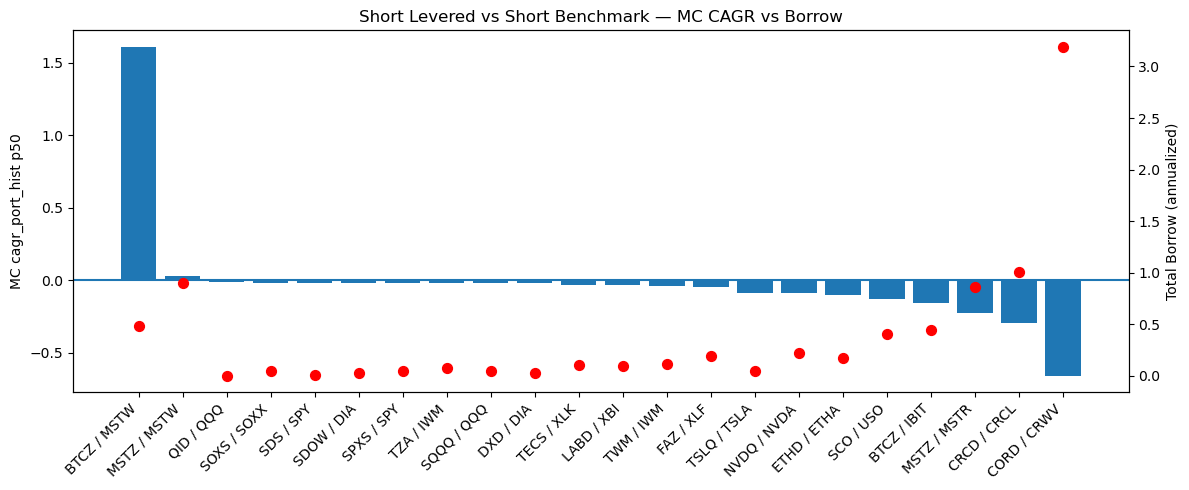

In [24]:
import matplotlib.pyplot as plt
import numpy as np

df = results_lev_vs_bench.copy()

df["pair"] = df["LegA"] + " / " + df["LegB"]
df["borrow_total"] = df["borrow_a"] + df["borrow_b"]

# Sort highest → lowest CAGR
df = df.sort_values("cagr_port_hist", ascending=False).reset_index(drop=True)

x = np.arange(len(df))

fig, ax1 = plt.subplots(figsize=(12, 5))

# --- Left axis: MC CAGR ---
ax1.bar(x, df["cagr_port_hist"])
ax1.axhline(0)
ax1.set_ylabel("MC cagr_port_hist p50")
ax1.set_xticks(x)
ax1.set_xticklabels(df["pair"], rotation=45, ha="right")

# --- Right axis: Borrow (red dots only) ---
ax2 = ax1.twinx()
ax2.scatter(
    x,
    df["borrow_total"],
    color="red",
    s=50,
    zorder=3
)
ax2.set_ylabel("Total Borrow (annualized)")

plt.title("Short Levered vs Short Benchmark — MC CAGR vs Borrow")
fig.tight_layout()
plt.show()


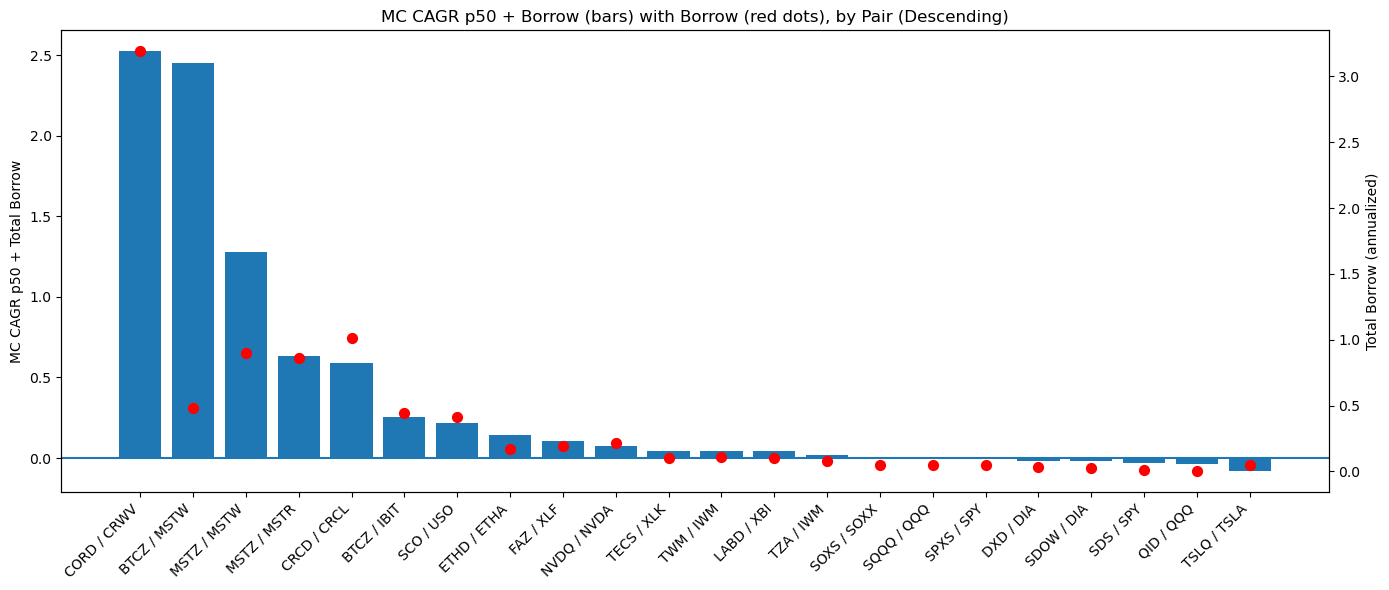

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = results_lev_vs_bench.copy()

# Pair label + total borrow
df["pair"] = df["LegA"].astype(str) + " / " + df["LegB"].astype(str)
df["borrow_total"] = (
    pd.to_numeric(df["borrow_a"], errors="coerce").fillna(0.0)
  + pd.to_numeric(df["borrow_b"], errors="coerce").fillna(0.0)
)

# Ensure numeric CAGR
df["mc_cagr_p50"] = pd.to_numeric(df["mc_cagr_p50"], errors="coerce")

# Metric to rank/plot (per your request)
df["cagr_plus_borrow"] = df["mc_cagr_p50"] + df["borrow_total"]

# Drop missing + sort descending
df_plot = (
    df.dropna(subset=["cagr_plus_borrow", "borrow_total"])
      .sort_values("cagr_plus_borrow", ascending=False)
      .reset_index(drop=True)
)

x = np.arange(len(df_plot))

# ---- One consolidated figure ----
fig, ax1 = plt.subplots(figsize=(14, 6))

# Bars: CAGR + Borrow
ax1.bar(x, df_plot["cagr_plus_borrow"])
ax1.axhline(0)
ax1.set_ylabel("MC CAGR p50 + Total Borrow")

ax1.set_xticks(x)
ax1.set_xticklabels(df_plot["pair"], rotation=45, ha="right")

# Dots: Borrow (right axis)
ax2 = ax1.twinx()
ax2.scatter(
    x,
    df_plot["borrow_total"],
    color="red",
    s=50,
    zorder=3
)
ax2.set_ylabel("Total Borrow (annualized)")

plt.title("MC CAGR p50 + Borrow (bars) with Borrow (red dots), by Pair (Descending)")
fig.tight_layout()
plt.show()


BTCZ / MSTW | Case: ShortBTCZ_ShortMSTW_0.5_1.0
weights: w_a=-0.466200, w_b=-0.667000
borrow:  BTCZ=44.2858%, MSTW=4.1682%
Hist CAGR: 1.1097087452449768
Mean CAGR: 0.1476055060890611
P10: 0.016937944402302438
P50: 0.14014838236623584
P90: 0.2873742430277602


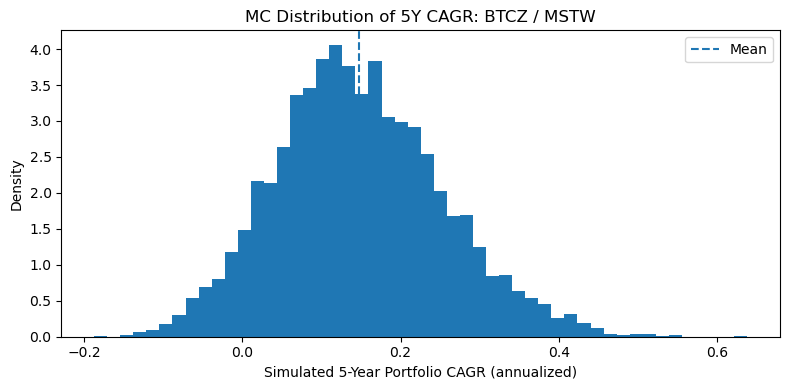

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------
# Choose the pair you want to inspect
# -----------------------------
legA = "BTCZ"
legB = "MSTW"   # or whatever your benchmark / other leg is

pair_to_view = pairs_lev_vs_bench[
    (pairs_lev_vs_bench["LegA"] == legA) &
    (pairs_lev_vs_bench["LegB"] == legB)
].iloc[0]

print(pair_to_view["LegA"], "/", pair_to_view["LegB"], "| Case:", pair_to_view.get("Case", ""))

# -----------------------------
# Pull weights + borrow
# -----------------------------
w_a = float(pair_to_view["w_a"])*1.4 if ("w_a" in pair_to_view and pd.notna(pair_to_view["w_a"])) else -0.5
w_b = float(pair_to_view["w_b"]) if ("w_b" in pair_to_view and pd.notna(pair_to_view["w_b"])) else -0.5

# Borrow map used in your batch run
borrow_a = float(borrow_map_pairs.get(legA, borrow_map_pairs.get("default", 0.05)))
borrow_b = float(borrow_map_pairs.get(legB, borrow_map_pairs.get("default", 0.05)))

print(f"weights: w_a={w_a:.6f}, w_b={w_b:.6f}")
print(f"borrow:  {legA}={borrow_a:.4%}, {legB}={borrow_b:.4%}")

# -----------------------------
# Load TR series and compute daily returns (same as batch)
# -----------------------------
trading_days = 252
prices_a = get_total_return_series(legA, start=None, end=None)
prices_b = get_total_return_series(legB, start=None, end=None)

_, ret_a = compute_leg_stats(prices_a, trading_days=trading_days)
_, ret_b = compute_leg_stats(prices_b, trading_days=trading_days)

# -----------------------------
# Historical daily-rebalanced path (for sanity)
# -----------------------------
port_ret_hist, equity_hist = portfolio_returns_twolegs_daily_rebalanced(
    ret_a, ret_b,
    w_a=w_a, w_b=w_b,
    borrow_a_annual=borrow_a,
    borrow_b_annual=borrow_b,
    trading_days=trading_days,
    initial_equity=1.0,
)

T = len(equity_hist)
cagr_hist = float(equity_hist.iloc[-1]) ** (trading_days / T) - 1.0
print("Hist CAGR:", cagr_hist)

# -----------------------------
# Monte Carlo with the NEW consistent engine
# -----------------------------
horizon_days = 252 * 5
n_sims = 5000

# -----------------------------
# If you want the FULL distribution (like your old sim_cagrs), add this helper
# -----------------------------
def simulate_two_leg_monte_carlo_rebalanced_full(
    ret_a: pd.Series,
    ret_b: pd.Series,
    w_a: float,
    w_b: float,
    borrow_a_annual: float,
    borrow_b_annual: float,
    horizon_days: int,
    n_sims: int,
    random_state: int | None,
    trading_days: int = 252,
    half_life_days: int | None = None,
    initial_equity: float = 1.0,
):
    rng = np.random.default_rng(random_state)
    ret_mat = pd.concat([ret_a.rename("a"), ret_b.rename("b")], axis=1).dropna()
    if ret_mat.shape[0] < 10:
        return np.array([])

    if half_life_days is None:
        mu = ret_mat.mean().values
        cov = ret_mat.cov().values
    else:
        mu = ret_mat.ewm(halflife=half_life_days, adjust=False).mean().iloc[-1].values
        ew_cov = ret_mat.ewm(halflife=half_life_days, adjust=False).cov()
        cov = ew_cov.xs(ew_cov.index.get_level_values(0).max(), level=0).values

    borrow_a_daily = borrow_a_annual / trading_days
    borrow_b_daily = borrow_b_annual / trading_days

    sim_cagrs = []

    for _ in range(n_sims):
        sim_daily = rng.multivariate_normal(mu, cov, size=horizon_days)

        equity = float(initial_equity)
        for t in range(horizon_days):
            rA, rB = sim_daily[t, 0], sim_daily[t, 1]
            notional_a = w_a * equity
            notional_b = w_b * equity

            pnl = notional_a * rA + notional_b * rB

            borrow_cost = 0.0
            if w_a < 0:
                borrow_cost += abs(notional_a) * borrow_a_daily
            if w_b < 0:
                borrow_cost += abs(notional_b) * borrow_b_daily

            equity = equity + pnl - borrow_cost
            if equity <= 0:
                equity = 0.0
                break

        # If it blew up, treat as -100% CAGR (or skip); here we include as -100%
        if equity <= 0:
            sim_cagrs.append(-1.0)
        else:
            cumulative = equity / initial_equity
            cagr = cumulative ** (trading_days / horizon_days) - 1.0
            sim_cagrs.append(cagr)

    return np.array(sim_cagrs)

sim_cagrs = simulate_two_leg_monte_carlo_rebalanced_full(
    ret_a=ret_a,
    ret_b=ret_b,
    w_a=w_a,
    w_b=w_b,
    borrow_a_annual=borrow_a,
    borrow_b_annual=borrow_b,
    horizon_days=horizon_days,
    n_sims=n_sims,
    random_state=42,
    trading_days=trading_days,
    half_life_days=252,
    initial_equity=1.0,
)

print("Mean CAGR:", sim_cagrs.mean())
print("P10:", np.percentile(sim_cagrs, 10))
print("P50:", np.percentile(sim_cagrs, 50))
print("P90:", np.percentile(sim_cagrs, 90))

plt.figure(figsize=(8, 4))
plt.hist(sim_cagrs, bins=50, density=True)
plt.axvline(sim_cagrs.mean(), linestyle="--", label="Mean")
plt.xlabel("Simulated 5-Year Portfolio CAGR (annualized)")
plt.ylabel("Density")
plt.title(f"MC Distribution of 5Y CAGR: {legA} / {legB}")
plt.legend()
plt.tight_layout()
plt.show()


In [74]:
import numpy as np
import pandas as pd

TRADING_DAYS = 252

# ------------------------------------------------------------
# 1) Beta estimation to BTC
# ------------------------------------------------------------
def beta_to_btc(asset_ret: pd.Series, btc_ret: pd.Series, min_obs: int = 60) -> float:
    df = pd.concat([asset_ret.rename("asset"), btc_ret.rename("btc")], axis=1).dropna()
    if len(df) < min_obs:
        return np.nan
    x = df["btc"].to_numpy()
    y = df["asset"].to_numpy()
    vx = np.var(x, ddof=1)
    if vx <= 0:
        return np.nan
    return float(np.cov(y, x, ddof=1)[0, 1] / vx)

def estimate_betas_to_btc(ret_df: pd.DataFrame, btc_col: str = "BTC", min_obs: int = 60) -> dict:
    betas = {}
    btc = ret_df[btc_col]
    for c in ret_df.columns:
        if c == btc_col:
            continue
        betas[c] = beta_to_btc(ret_df[c], btc, min_obs=min_obs)
    return betas


# ------------------------------------------------------------
# 2) Rebalanced portfolio backtest with borrow on shorts
# ------------------------------------------------------------
def portfolio_returns_rebalanced(
    ret_df: pd.DataFrame,          # daily returns, columns = symbols
    weights: dict,                 # target weights (notionals = weight * equity at rebalance)
    borrow_annual: dict,           # annual borrow rate by symbol (only charged if position < 0)
    trading_days: int = TRADING_DAYS,
    initial_equity: float = 1.0,
    rebalance: str = "daily",      # "daily","weekly","monthly","quarterly","never"
    rebalance_days: int | None = None,
):
    w = pd.Series(weights, dtype=float)
    ret_df = ret_df[w.index].dropna()

    if rebalance_days is None:
        mapping = {"daily": 1, "weekly": 5, "monthly": 21, "quarterly": 63, "never": 10**9}
        if rebalance not in mapping:
            raise ValueError(f"Unknown rebalance='{rebalance}'")
        rebalance_days = mapping[rebalance]

    borrow_daily = {k: float(v) / trading_days for k, v in borrow_annual.items()}

    equity = float(initial_equity)
    equity_path = []
    port_ret_path = []

    notionals = {sym: 0.0 for sym in w.index}

    def do_rebalance():
        # notionals are set from CURRENT equity at rebalance time
        for sym, wi in w.items():
            notionals[sym] = float(wi) * equity

    do_rebalance()
    prev_equity = equity

    for t, (dt, row) in enumerate(ret_df.iterrows()):
        # rebalance at START of day
        if t > 0 and (t % rebalance_days == 0):
            do_rebalance()

        pnl = 0.0
        borrow_cost = 0.0

        for sym in w.index:
            r = float(row[sym])
            notional = float(notionals[sym])

            pnl += notional * r

            # charge borrow if actually short
            if notional < 0:
                borrow_cost += abs(notional) * borrow_daily.get(sym, 0.0)

        equity = equity + pnl - borrow_cost

        if equity <= 0:
            equity = 0.0
            equity_path.append(equity)
            port_ret_path.append(-1.0)
            break

        equity_path.append(equity)
        port_ret_path.append(equity / prev_equity - 1.0)
        prev_equity = equity

    equity_series = pd.Series(equity_path, index=ret_df.index[:len(equity_path)], name="equity")
    port_ret = pd.Series(port_ret_path, index=ret_df.index[:len(port_ret_path)], name="port_ret").fillna(0.0)
    return port_ret, equity_series


# ------------------------------------------------------------
# 3) Stats (CAGR computed generally)
# ------------------------------------------------------------
def compute_stats(port_ret: pd.Series, equity: pd.Series, trading_days: int = TRADING_DAYS):
    if equity is None or len(equity) < 10:
        return None

    # Use ratio so it works even if initial_equity != 1
    start = float(equity.iloc[0])
    end = float(equity.iloc[-1])
    if start <= 0:
        return None

    T = len(equity)
    cagr = (end / start) ** (trading_days / T) - 1.0

    vol = float(port_ret.std(ddof=1) * np.sqrt(trading_days))
    denom = (port_ret.std(ddof=1) * np.sqrt(trading_days) + 1e-12)
    sharpe = float((port_ret.mean() * trading_days) / denom)

    roll_max = equity.cummax()
    maxdd = float((equity / roll_max - 1.0).min())

    return {"CAGR": float(cagr), "Vol": vol, "Sharpe": sharpe, "MaxDD": maxdd}


# ------------------------------------------------------------
# 4) Generic grid search with net-beta-to-BTC neutrality
#    - grid searches all legs except 1 "hedge_leg"
#    - solves hedge_leg weight to force net beta ~= 0
# ------------------------------------------------------------
def grid_search_beta_neutral(
    ret_df_all: pd.DataFrame,      # must include btc_col + all legs
    longs: list[str],
    shorts: list[str],
    btc_col: str,
    betas: dict,                   # beta per symbol (NOT including BTC)
    borrow_annual: dict,
    grid_long=(0.2, 2.0, 0.2),     # (min, max, step) for each long weight (positive)
    grid_short=(0.2, 2.0, 0.2),    # (min, max, step) for each short abs-weight (positive; actual weight negative)
    hedge_leg: str | None = None,  # which single leg gets solved for neutrality
    gross_cap: float = 3.0,
    rebalance: str = "daily",
    min_obs_beta: int = 60,
    net_beta_tol: float = 1e-10,   # construction tolerance
    realized_beta_check: bool = True,
):
    legs = list(longs) + list(shorts)

    # choose hedge leg
    if hedge_leg is None:
        # default: first short if available, else last long
        hedge_leg = shorts[0] if len(shorts) else longs[-1]
    if hedge_leg not in legs:
        raise ValueError(f"hedge_leg='{hedge_leg}' must be in longs+shorts")

    # align returns
    needed_cols = [btc_col] + legs
    missing = [c for c in needed_cols if c not in ret_df_all.columns]
    if missing:
        raise ValueError(f"ret_df_all missing columns: {missing}")

    ret_df = ret_df_all[needed_cols].dropna()
    btc_series = ret_df[btc_col]
    ret_legs = ret_df[legs]

    # validate betas
    for sym in legs:
        b = betas.get(sym, np.nan)
        if not np.isfinite(b):
            raise ValueError(f"Missing/invalid beta for {sym}: {b}")

    b_hedge = float(betas[hedge_leg])
    if abs(b_hedge) < 1e-12:
        raise ValueError(f"hedge_leg '{hedge_leg}' beta ~ 0; can't solve neutrality.")

    # build grids
    minL, maxL, stepL = grid_long
    minS, maxS, stepS = grid_short
    long_grid = np.arange(minL, maxL + 1e-12, stepL)
    short_grid = np.arange(minS, maxS + 1e-12, stepS)

    # which legs are free vs solved
    free_longs = [x for x in longs if x != hedge_leg]
    free_shorts = [x for x in shorts if x != hedge_leg]
    free_legs = free_longs + free_shorts

    # create per-leg grids (same range for all longs, same for all shorts)
    per_leg_vals = {}
    for sym in free_legs:
        if sym in longs:
            per_leg_vals[sym] = long_grid
        else:
            per_leg_vals[sym] = short_grid  # abs weights; sign applied later

    # recursive grid iterator (keeps it general for any number of legs)
    results = []

    def rec_build(idx: int, w_partial: dict):
        if idx == len(free_legs):
            # solve hedge leg to make net beta = 0
            net_wo_hedge = 0.0
            for sym, w in w_partial.items():
                net_wo_hedge += float(w) * float(betas[sym])
            w_hedge = -net_wo_hedge / b_hedge

            weights = dict(w_partial)
            weights[hedge_leg] = float(w_hedge)

            # enforce sign convention:
            #   longs should be >= 0, shorts should be <= 0
            for sym in longs:
                if sym in weights and weights[sym] < 0:
                    return
            for sym in shorts:
                if sym in weights and weights[sym] > 0:
                    return

            gross = sum(abs(float(v)) for v in weights.values())
            if gross > gross_cap:
                return

            net_beta = sum(float(weights[sym]) * float(betas[sym]) for sym in legs)
            if abs(net_beta) > net_beta_tol:
                return

            port_ret, equity = portfolio_returns_rebalanced(
                ret_df=ret_legs,
                weights=weights,
                borrow_annual=borrow_annual,
                trading_days=TRADING_DAYS,
                initial_equity=1.0,
                rebalance=rebalance,
            )
            stats = compute_stats(port_ret, equity, trading_days=TRADING_DAYS)
            if stats is None:
                return

            realized_beta = np.nan
            if realized_beta_check:
                realized_beta = beta_to_btc(port_ret, btc_series.loc[port_ret.index], min_obs=min_obs_beta)

            results.append({
                **{f"w_{k}": float(v) for k, v in weights.items()},
                "Gross": float(gross),
                "NetBeta_Constr": float(net_beta),
                "Beta_to_BTC_realized": float(realized_beta) if np.isfinite(realized_beta) else np.nan,
                "Rebalance": rebalance,
                **stats,
            })
            return

        sym = free_legs[idx]
        vals = per_leg_vals[sym]

        if sym in longs:
            # positive
            for v in vals:
                w_partial[sym] = float(v)
                rec_build(idx + 1, w_partial)
        else:
            # shorts are negative
            for v in vals:
                w_partial[sym] = -float(v)
                rec_build(idx + 1, w_partial)

        w_partial.pop(sym, None)

    rec_build(0, {})
    return pd.DataFrame(results)


# ------------------------------------------------------------
# Example usage with your pipeline:
# - You provide get_total_return_series + compute_leg_stats
# - Build ret_mat with BTC + assets
# - Estimate betas
# - Run grid search
# ------------------------------------------------------------

longs  = []
shorts = ["BTCZ", "MSTW", "MSII", "XBTY", "MTYY"]
btc_proxy = "BTC"  # or "IBIT"

def get_daily_returns(sym: str) -> pd.Series:
    px = get_total_return_series(sym, start=None, end=None)
    _, ret = compute_leg_stats(px, trading_days=TRADING_DAYS)
    return ret

rets = {s: get_daily_returns(s) for s in (longs + shorts)}
ret_btc = get_daily_returns(btc_proxy)

ret_mat = pd.concat(
    [ret_btc.rename("BTC")] + [rets[s].rename(s) for s in longs + shorts],
    axis=1
).dropna()

betas = estimate_betas_to_btc(ret_mat, btc_col="BTC", min_obs=60)
borrow = {s: float(borrow_map_pairs.get(s, borrow_map_pairs.get("default", 0.015))) for s in (longs + shorts)}
print(betas)
print(borrow)
df_res = grid_search_beta_neutral(
    ret_df_all=ret_mat,
    longs=longs,
    shorts=shorts,
    btc_col="BTC",
    betas=betas,
    borrow_annual=borrow,
    grid_long=(0.1, 2.9, 0.2),
    grid_short=(0.1, 2.9, 0.2),
    hedge_leg=None,          # defaults to first short
    gross_cap=3.0,
    rebalance="monthly",
)
df_res.sort_values(["Sharpe", "CAGR"], ascending=False).head(20)


{'BTCZ': -2.012250269804888, 'MSTW': 1.4752286349138992, 'MSII': 1.2802426403082376, 'XBTY': 0.6564623046554763, 'MTYY': 0.6315273472474102}
{'BTCZ': 0.442858, 'MSTW': 0.041682, 'MSII': 0.07957, 'XBTY': 0.0, 'MTYY': 0.09201200000000001}


,w_MSTW,w_MSII,w_XBTY,w_MTYY,w_BTCZ,Gross,NetBeta_Constr,Beta_to_BTC_realized,Rebalance,CAGR,Vol,Sharpe,MaxDD
39,-0.1,-0.1,-0.9,-1.1,-0.775770,2.975770,1.110223e-16,0.008767,monthly,7.190046,0.360094,6.188300,-0.074454
33,-0.1,-0.1,-0.7,-1.3,-0.773292,2.973292,1.110223e-16,0.010980,monthly,8.692758,0.391920,6.186340,-0.082956
32,-0.1,-0.1,-0.7,-1.1,-0.710523,2.710523,0.000000e+00,0.008533,monthly,6.552703,0.347388,6.180680,-0.073270
31,-0.1,-0.1,-0.7,-0.9,-0.647755,2.447755,1.110223e-16,0.006381,monthly,4.847064,0.302843,6.159034,-0.063895
38,-0.1,-0.1,-0.9,-0.9,-0.713002,2.713002,0.000000e+00,0.006626,monthly,5.353998,0.316807,6.150089,-0.065050
25,-0.1,-0.1,-0.5,-1.3,-0.708045,2.708045,1.110223e-16,0.010778,monthly,7.947958,0.382016,6.138250,-0.083716
26,-0.1,-0.1,-0.5,-1.5,-0.770813,2.970813,0.000000e+00,0.013520,monthly,10.435417,0.426954,6.136292,-0.094569
24,-0.1,-0.1,-0.5,-1.1,-0.645277,2.445277,0.000000e+00,0.008319,monthly,5.957927,0.336705,6.134821,-0.072592
23,-0.1,-0.1,-0.5,-0.9,-0.582509,2.182509,1.110223e-16,0.006158,monthly,4.374822,0.291134,6.120224,-0.062750
44,-0.1,-0.1,-1.1,-0.9,-0.778248,2.978248,-1.110223e-16,0.006896,monthly,5.897739,0.332709,6.105450,-0.066215


In [72]:
# Now you can rank WITHOUT beta penalty, because construction is neutral.
# But keep realized Beta_to_BTC visible (it will drift more when rebalance is slower).
top_by_freq = (
    df_res
        .sort_values(["CAGR"], ascending=False)
        .head(10)
)
top_by_freq


,w_MSTW,w_MSII,w_XBTY,w_BTCZ,Gross,NetBeta_Constr,Beta_to_BTC_realized,Rebalance,CAGR,Vol,Sharpe,MaxDD
147,-1.5,-0.1,-0.1,-1.178197,2.878197,1.526557e-16,0.017684,monthly,4.080715,0.585625,3.063938,-0.162433
146,-1.3,-0.3,-0.1,-1.159380,2.859380,2.914335e-16,0.017235,monthly,3.778387,0.579419,2.984488,-0.162215
143,-1.1,-0.5,-0.1,-1.140564,2.840564,4.024558e-16,0.016782,monthly,3.491403,0.573994,2.899213,-0.161996
145,-1.3,-0.1,-0.3,-1.102559,2.802559,2.775558e-16,0.014139,monthly,3.384895,0.519274,3.098764,-0.141979
136,-0.9,-0.7,-0.1,-1.121747,2.821747,1.804112e-16,0.016323,monthly,3.219135,0.569386,2.808128,-0.161777
144,-1.3,-0.1,-0.1,-1.034029,2.534029,3.747003e-16,0.013775,monthly,3.203992,0.516589,3.033328,-0.144571
142,-1.1,-0.3,-0.3,-1.083743,2.783743,-2.775558e-17,0.013701,monthly,3.119981,0.513330,3.007143,-0.141617
124,-0.7,-0.9,-0.1,-1.102931,2.802931,4.024558e-16,0.015859,monthly,2.960972,0.565626,2.711324,-0.161558
141,-1.1,-0.3,-0.1,-1.015213,2.515213,6.938894e-17,0.013358,monthly,2.950824,0.510280,2.942676,-0.144225
140,-1.1,-0.1,-0.7,-1.095452,2.995452,-5.551115e-17,0.011187,monthly,2.929210,0.461702,3.180437,-0.117837


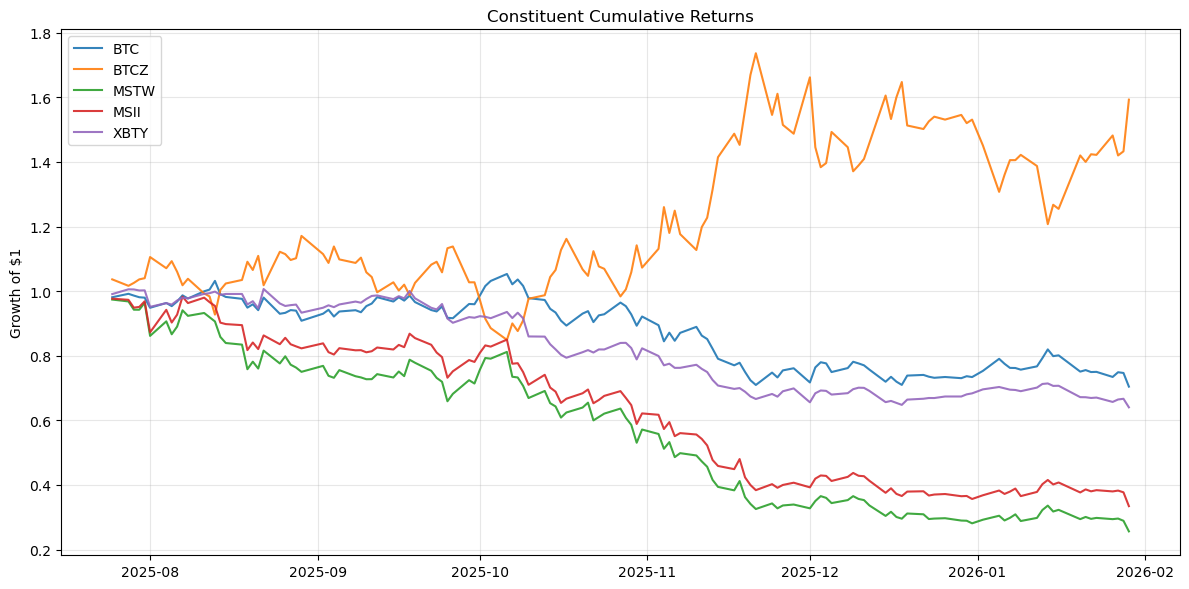

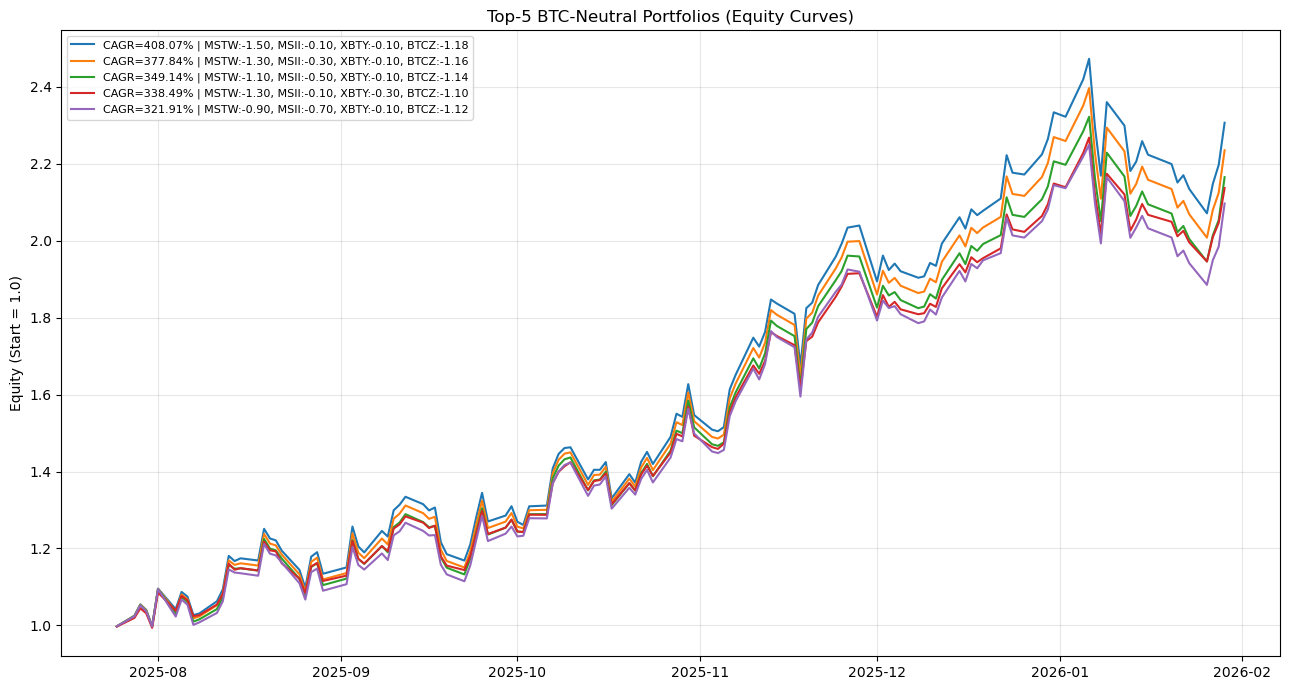

In [73]:
import matplotlib.pyplot as plt

def cum_returns(ret: pd.Series, start: float = 1.0) -> pd.Series:
    return start * (1 + ret.fillna(0)).cumprod()

def plot_constituents(ret_mat: pd.DataFrame):
    plt.figure(figsize=(12, 6))

    for col in ret_mat.columns:
        cr = cum_returns(ret_mat[col])
        plt.plot(cr.index, cr.values, label=col, alpha=0.9)

    plt.title("Constituent Cumulative Returns")
    plt.ylabel("Growth of $1")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

top5 = (
    df_res
        .sort_values("CAGR", ascending=False)
        .head(5)
        .reset_index(drop=True)
)

def run_portfolio_from_row(row, ret_legs, borrow, rebalance):
    weights = {
        k.replace("w_", ""): row[k]
        for k in row.index
        if k.startswith("w_")
    }

    _, equity = portfolio_returns_rebalanced(
        ret_df=ret_legs,
        weights=weights,
        borrow_annual=borrow,
        trading_days=TRADING_DAYS,
        initial_equity=1.0,
        rebalance=rebalance,
    )
    return equity


def plot_top_portfolios(top_df, ret_mat, borrow):
    ret_legs = ret_mat[[c for c in ret_mat.columns]]

    plt.figure(figsize=(13, 7))

    for i, row in top_df.iterrows():
        equity = run_portfolio_from_row(
            row,
            ret_legs=ret_legs,
            borrow=borrow,
            rebalance=row["Rebalance"],
        )

        label = (
            f"CAGR={row['CAGR']:.2%} | "
            + ", ".join(
                f"{k.replace('w_', '')}:{row[k]:.2f}"
                for k in row.index if k.startswith("w_")
            )
        )

        plt.plot(equity.index, equity.values, label=label)

    plt.title("Top-5 BTC-Neutral Portfolios (Equity Curves)")
    plt.ylabel("Equity (Start = 1.0)")
    plt.legend(fontsize=8)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_constituents(ret_mat)

plot_top_portfolios(top5, ret_mat, borrow)


In [31]:
data = [
    ("2026-01-05", 0.160759),
    ("2025-12-29", 0.162949),
    ("2025-12-22", 0.211471),
    ("2025-12-15", 0.241907),
    ("2025-12-08", 0.248806),
    ("2025-12-01", 0.162049),
    ("2025-11-24", 0.147426),
    ("2025-11-17", 0.232022),
    ("2025-11-10", 0.27678),
    ("2025-11-03", 0.375394),
    ("2025-10-27", 0.358866),
    ("2025-10-20", 0.389369),
    ("2025-10-14", 0.836939),
    ("2025-10-06", 0.438159),
    ("2025-09-29", 0.793874),
    ("2025-09-22", 0.84821),
    ("2025-09-15", 0.51068),
    ("2025-09-08", 0.355776),
    ("2025-09-02", 0.457825),
    ("2025-08-25", 0.40676),
    ("2025-08-18", 1.393529),
    ("2025-08-11", 0.785542),
    ("2025-08-04", 0.856739),
]
data

[('2026-01-05', 0.160759),
 ('2025-12-29', 0.162949),
 ('2025-12-22', 0.211471),
 ('2025-12-15', 0.241907),
 ('2025-12-08', 0.248806),
 ('2025-12-01', 0.162049),
 ('2025-11-24', 0.147426),
 ('2025-11-17', 0.232022),
 ('2025-11-10', 0.27678),
 ('2025-11-03', 0.375394),
 ('2025-10-27', 0.358866),
 ('2025-10-20', 0.389369),
 ('2025-10-14', 0.836939),
 ('2025-10-06', 0.438159),
 ('2025-09-29', 0.793874),
 ('2025-09-22', 0.84821),
 ('2025-09-15', 0.51068),
 ('2025-09-08', 0.355776),
 ('2025-09-02', 0.457825),
 ('2025-08-25', 0.40676),
 ('2025-08-18', 1.393529),
 ('2025-08-11', 0.785542),
 ('2025-08-04', 0.856739)]

In [32]:
ticker = "MSTW"
t = yf.Ticker(ticker)

df = t.history(period='max', auto_adjust=False, actions=True)

close = df["Close"]
divs = df.get("Dividends", pd.Series(0.0, index=df.index))
divs = divs.reindex(close.index, fill_value=0.0)
rel = (close + divs) / close.shift(1)
rel.iloc[0] = 1.0

tr_price = close.iloc[0] * rel.cumprod()
tr_price.name = ticker + "_TR"


In [62]:
# ============================================================
# Time-Diversified "Short/Short" Simulation
# - Per-pair sims (each starts at later inception of both legs)
# - Portfolio sim across ALL pairs (daily adds spread across active pairs)
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

TRADING_DAYS = 252
DEFAULT_BORROW = 0.05

# -----------------------------
# Helpers
# -----------------------------
def _get_borrow(sym: str, default: float = DEFAULT_BORROW) -> float:
    try:
        return float(borrow_map_pairs.get(str(sym).upper(), default))
    except Exception:
        return default

def _get_aligned_returns(leg_a: str, leg_b: str) -> pd.DataFrame:
    """Return df with columns A,B of daily returns on aligned TR index."""
    tr_a = get_total_return_series(str(leg_a).upper())
    tr_b = get_total_return_series(str(leg_b).upper())
    px = pd.concat([tr_a, tr_b], axis=1).dropna()
    px.columns = ["A", "B"]
    rets = px.pct_change().dropna()
    return rets

def run_shortshort_daily_add_pair(
    leg_a: str,
    leg_b: str,
    daily_add_frac: float = 0.001,
    split_a: float = 0.5,
    initial_equity: float = 1.0,
    borrow_a: float | None = None,
    borrow_b: float | None = None,
) -> pd.DataFrame:
    """
    Daily-add short/short simulation for one pair.
    Starts on later inception automatically because _get_aligned_returns does dropna alignment.
    """
    leg_a = str(leg_a).upper()
    leg_b = str(leg_b).upper()

    rets = _get_aligned_returns(leg_a, leg_b)

    BORROW_A = _get_borrow(leg_a) if borrow_a is None else float(borrow_a)
    BORROW_B = _get_borrow(leg_b) if borrow_b is None else float(borrow_b)

    equity = float(initial_equity)
    short_a = 0.0
    short_b = 0.0

    rows = []
    for dt, row in rets.iterrows():
        ra = float(row["A"])
        rb = float(row["B"])

        pnl = -short_a * ra - short_b * rb
        borrow = (BORROW_A / TRADING_DAYS) * short_a + (BORROW_B / TRADING_DAYS) * short_b

        equity = equity + pnl - borrow

        add_total = daily_add_frac * equity
        add_a = split_a * add_total
        add_b = (1 - split_a) * add_total

        short_a += add_a
        short_b += add_b

        rows.append({
            "Date": dt,
            "Equity": equity,
            "ShortA": short_a,
            "ShortB": short_b,
            "GrossShort": short_a + short_b,
            "GrossShort_pct_equity": (short_a + short_b) / equity if equity != 0 else np.nan,
            "BorrowCost": borrow,
            "PnL": pnl,
            "AddTotal": add_total,
            "RetA": ra,
            "RetB": rb,
            "LegA": leg_a,
            "LegB": leg_b,
            "BorrowA": BORROW_A,
            "BorrowB": BORROW_B,
        })

    sim = pd.DataFrame(rows).set_index("Date")
    return sim

def summarize_sim(sim: pd.DataFrame) -> dict:
    equity_curve = sim["Equity"]
    daily_ret = equity_curve.pct_change().dropna()
    if len(daily_ret) == 0:
        return {}

    cagr = equity_curve.iloc[-1] ** (TRADING_DAYS / len(daily_ret)) - 1
    vol = daily_ret.std(ddof=1) * np.sqrt(TRADING_DAYS)
    dd = equity_curve / equity_curve.cummax() - 1
    max_dd = float(dd.min())

    out = {
        "Start": sim.index.min(),
        "End": sim.index.max(),
        "Days": int(len(daily_ret)),
        "CAGR": float(cagr),
        "AnnVol": float(vol),
        "MaxDD": max_dd,
        "EndEquity": float(equity_curve.iloc[-1]),
        "AvgGrossShortPctEq": float(sim["GrossShort_pct_equity"].mean()),
        "P10GrossShortPctEq": float(sim["GrossShort_pct_equity"].quantile(0.10)),
        "P90GrossShortPctEq": float(sim["GrossShort_pct_equity"].quantile(0.90)),
    }
    # carry leg info if present
    for k in ["LegA", "LegB", "BorrowA", "BorrowB"]:
        if k in sim.columns:
            out[k] = sim[k].iloc[-1]
    return out

# -----------------------------
# Build pair list
# -----------------------------
# Choose your pair universe. Here are common options:
# - results_shortshort_mc (LegA/LegB columns)
# - pairs_lev_vs_bench (if you used it earlier)
# Fallback uses the unique pairs in results_shortshort_mc if available.

PAIRS = []
try:
    _df = results_shortshort_mc.copy()
    PAIRS = list({(str(r["LegA"]).upper(), str(r["LegB"]).upper()) for _, r in _df.iterrows()})
except Exception:
    pass

if not PAIRS:
    raise ValueError("No PAIRS found. Provide a list like PAIRS=[('SDS','SQQQ'), ...]")

print(f"Found {len(PAIRS)} pairs.")

# -----------------------------
# (A) Run per-pair sims
# -----------------------------
DAILY_ADD_FRAC = 0.0006   # total add per day per pair as % of that pair-equity
SPLIT_A = 0.3

pair_sims = {}
pair_summaries = []

for (a, b) in sorted(PAIRS):
    try:
        sim = run_shortshort_daily_add_pair(a, b, daily_add_frac=DAILY_ADD_FRAC, split_a=SPLIT_A)
        pair_sims[(a, b)] = sim
        s = summarize_sim(sim)
        s["Pair"] = f"{a}/{b}"
        pair_summaries.append(s)
    except Exception as e:
        print("Skipping", a, b, "->", repr(e))

pair_summary_df = pd.DataFrame(pair_summaries).sort_values("CAGR", ascending=False)
display(pair_summary_df.head(20))

# Optional: save per-pair summaries
pair_summary_df.to_csv("shortshort_pair_summaries.csv", index=False)
print("Saved: shortshort_pair_summaries.csv")


Found 22 pairs.


C:\Users\werdn\AppData\Local\Temp\ipykernel_19108\289675271.py:101: RuntimeWarning: invalid value encountered in scalar power
  cagr = equity_curve.iloc[-1] ** (TRADING_DAYS / len(daily_ret)) - 1


,Start,End,Days,CAGR,AnnVol,MaxDD,EndEquity,AvgGrossShortPctEq,P10GrossShortPctEq,P90GrossShortPctEq,LegA,LegB,BorrowA,BorrowB,Pair
12,2010-03-12 00:00:00-05:00,2026-01-29 00:00:00-05:00,3995,0.183889,0.257467,-0.439654,14.528296,0.586679,0.243562,0.798952,SOXL,SOXS,0.000000,0.050000,SOXL/SOXS
17,2010-02-12 00:00:00-05:00,2026-01-29 00:00:00-05:00,4014,0.130871,0.199275,-0.357102,7.092394,0.673830,0.238356,0.951777,TQQQ,SQQQ,0.000000,0.050000,TQQQ/SQQQ
15,2008-12-31 00:00:00-05:00,2026-01-29 00:00:00-05:00,4295,0.125886,0.220618,-0.374470,7.544857,0.709113,0.254797,0.975853,TECL,TECS,0.000000,0.103536,TECL/TECS
11,2006-07-14 00:00:00-04:00,2026-01-29 00:00:00-05:00,4916,0.113283,0.149367,-0.277376,8.112923,0.782647,0.298480,1.078963,QLD,QID,0.000000,0.002488,QLD/QID
0,2008-12-05 00:00:00-05:00,2026-01-29 00:00:00-05:00,4312,0.104051,0.302675,-0.723352,5.439876,1.169242,0.250554,1.959968,AGQ,ZSL,0.000000,0.044112,AGQ/ZSL
13,2008-11-20 00:00:00-05:00,2026-01-29 00:00:00-05:00,4322,0.102057,0.202264,-0.441322,5.294601,0.785884,0.256756,1.161782,SPXL,SPXS,0.000000,0.050000,SPXL/SPXS
9,2010-12-09 00:00:00-05:00,2026-01-29 00:00:00-05:00,3806,0.096361,0.359104,-0.581633,4.012589,0.853344,0.235989,1.348530,NUGT,DUST,0.033360,0.061234,NUGT/DUST
20,2010-02-12 00:00:00-05:00,2026-01-29 00:00:00-05:00,4014,0.088794,0.199196,-0.464836,3.876958,0.781461,0.241633,1.220554,UDOW,SDOW,0.018080,0.024452,UDOW/SDOW
14,2006-07-14 00:00:00-04:00,2026-01-29 00:00:00-05:00,4916,0.081728,0.149645,-0.347841,4.629901,0.899752,0.304574,1.316991,SSO,SDS,0.000000,0.010876,SSO/SDS
4,2006-07-14 00:00:00-04:00,2026-01-29 00:00:00-05:00,4916,0.063145,0.160439,-0.413176,3.301927,0.971259,0.306074,1.531831,DDM,DXD,0.000000,0.029704,DDM/DXD


Saved: shortshort_pair_summaries.csv


In [63]:
# reverse map: benchmark ETF -> key (e.g., "GDX" -> "GDX")
bench_values = {v.upper(): k for k, v in benchmark_map.items()}
levered_to_bench = {
    "DUST": "GDX",
    "NUGT": "GDX",
    "JDST": "GDX",
    
    "ZSL": "SLV",

    "SOXL": "SOXX",
    "SOXS": "SOXX",

    "TQQQ": "QQQ",
    "SQQQ": "QQQ",

    "UPRO": "SPY",
    "SPXU": "SPY",

    "TSLL": "TSLA",
    "TSLS": "TSLA",

    "MSTU": "MSTR",
    "MSTX": "MSTR",

    "BITX": "IBIT",
    "SBIT": "IBIT",
}

def benchmark_from_pair(a: str, b: str) -> str | None:
    a = a.upper()
    b = b.upper()

    if a in levered_to_bench:
        return levered_to_bench[a]
    if b in levered_to_bench:
        return levered_to_bench[b]
    return None

def benchmark_equity_curve_daily_add_long(
    benchmark_etf: str,
    dates: pd.DatetimeIndex,
    daily_add_frac: float = 0.0002,   # 0.02% per day
    initial_equity: float = 1.0,
) -> pd.Series:
    """
    Simulate a benchmark that DCA's into a 1x long position:
    - Each day: PnL = long_notional * return
    - Then add new notional = daily_add_frac * equity
    - Starts with 0 exposure, like your short/short sim.
    """
    tr = get_total_return_series(benchmark_etf.upper()).dropna()
    tr = tr.reindex(dates).dropna()
    if len(tr) < 2:
        return pd.Series(dtype=float)

    rets = tr.pct_change().dropna()

    equity = float(initial_equity)
    long_notional = 0.0
    eq_path = []

    for dt, r in rets.items():
        pnl = long_notional * float(r)
        equity = equity + pnl

        add = daily_add_frac * equity
        long_notional += add

        eq_path.append((dt, equity))

    return pd.Series([v for _, v in eq_path], index=[d for d, _ in eq_path], name="Equity")


def stats_from_equity(eq: pd.Series) -> dict:
    eq = eq.dropna()
    if len(eq) < 3:
        return {}

    daily = eq.pct_change().dropna()
    cagr = eq.iloc[-1] ** (TRADING_DAYS / len(daily)) - 1
    vol = daily.std(ddof=1) * np.sqrt(TRADING_DAYS)
    dd = eq / eq.cummax() - 1
    maxdd = float(dd.min())

    return {
        "CAGR": float(cagr),
        "AnnVol": float(vol),
        "MaxDD": float(maxdd),
        "EndEquity": float(eq.iloc[-1]),
    }
pair_compare_rows = []

for (a, b), sim in pair_sims.items():
    bench_etf = benchmark_from_pair(a, b)
    if bench_etf is None:
        continue

    strat_eq = sim["Equity"].dropna()
    bench_eq = benchmark_equity_curve_daily_add_long(
        bench_etf,
        strat_eq.index,
        daily_add_frac=DAILY_ADD_FRAC*2,          # <-- 0.0002
        initial_equity=strat_eq.iloc[0],
    )

    if bench_eq.empty:
        continue

    strat_stats = stats_from_equity(strat_eq.reindex(bench_eq.index).dropna())
    bench_stats = stats_from_equity(bench_eq)

    if not strat_stats or not bench_stats:
        continue

    pair_compare_rows.append({
        "Pair": f"{a}/{b}",
        "Benchmark": bench_etf,
        "Strat_CAGR": strat_stats["CAGR"],
        "Strat_Vol": strat_stats["AnnVol"],
        "Strat_MaxDD": strat_stats["MaxDD"],
        "Bench_CAGR": bench_stats["CAGR"],
        "Bench_Vol": bench_stats["AnnVol"],
        "Bench_MaxDD": bench_stats["MaxDD"],
        "Excess_CAGR": strat_stats["CAGR"] - bench_stats["CAGR"],
    })

pair_compare_df = pd.DataFrame(pair_compare_rows)

display(pair_compare_df.sort_values("Excess_CAGR", ascending=False).head(25))


,Pair,Benchmark,Strat_CAGR,Strat_Vol,Strat_MaxDD,Bench_CAGR,Bench_Vol,Bench_MaxDD,Excess_CAGR
1,MSTU/MSTZ,MSTR,-0.131781,0.067515,-0.192528,-0.174961,0.169793,-0.316205,0.043180
0,AGQ/ZSL,SLV,0.104712,0.302736,-0.723352,0.171092,2.376872,-1.144444,-0.066379
2,NUGT/DUST,GDX,0.096387,0.359151,-0.581633,0.185041,0.859656,-0.916808,-0.088654
4,TQQQ/SQQQ,QQQ,0.130905,0.199300,-0.357102,0.221778,0.255807,-0.425709,-0.090873
3,SOXL/SOXS,SOXX,0.183940,0.257499,-0.439654,0.274831,0.331643,-0.496253,-0.090892


Pairs total: 22
Pairs kept (BorrowA+BorrowB < 20%): 14
Pairs skipped: 8

=== PORTFOLIO: Time-Diversified Short/Short Across FILTERED Pairs ===
TOTAL_DAILY_ADD_FRAC: 0.0002
LEG_SPLIT_X (A,B): 0 , 1.0
Borrow filter: BorrowA + BorrowB < 0.2
Pairs kept: 14
CAGR: 0.09394337734404878
Ann Vol: 0.15458515432098935
Max Drawdown: -0.3336457444678157
Ending Equity (start=1): 5.763800361781533
Avg gross short / equity: 0.2982283290089698


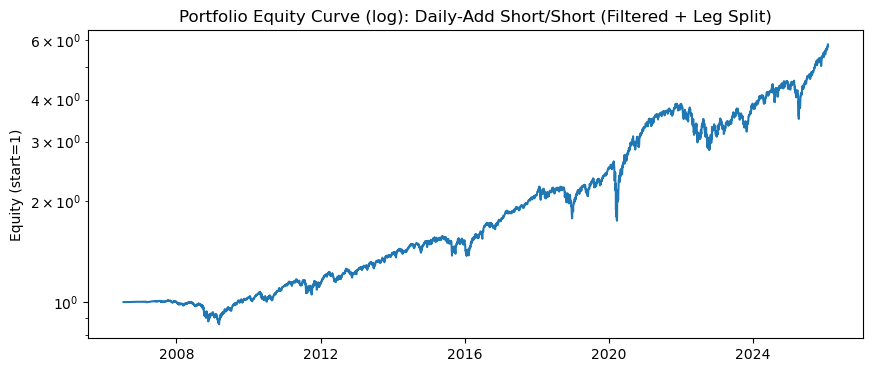

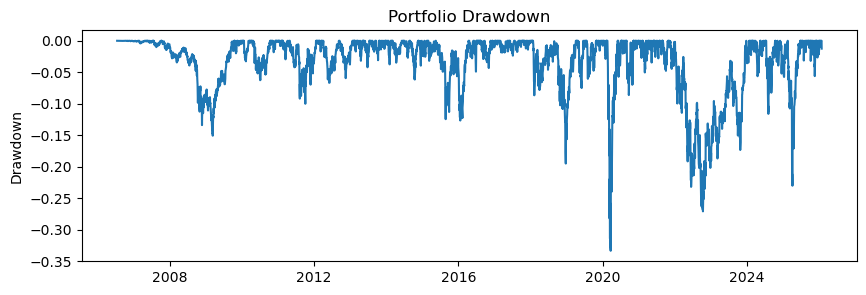

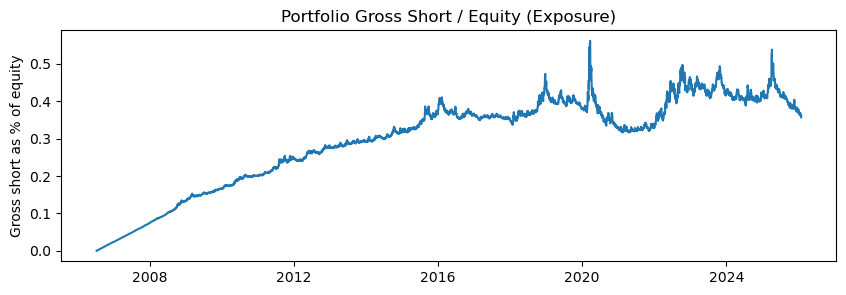

Saved: shortshort_portfolio_daily_add_all_pairs_filtered_split.csv


In [44]:
# -----------------------------
# (B) Portfolio sim across ALL pairs (WITH leg split + borrow filter)
# -----------------------------

TOTAL_DAILY_ADD_FRAC = 0.0002   # portfolio-level daily add as % of portfolio equity
INITIAL_EQUITY = 1.0
LEG_SPLIT_X = 0              # <-- x goes to LegA, (1-x) goes to LegB
MAX_SUM_BORROW = 0.2           # <-- include only pairs where BorrowA + BorrowB < 25%

# 1) Prepare aligned return frames for each pair + filter by borrow sum
pair_rets = {}
pair_start = {}
pair_end = {}
pair_borrow = {}

kept_pairs = []
skipped_pairs = []

for (a, b) in sorted(PAIRS):
    a = str(a).upper()
    b = str(b).upper()

    BA = _get_borrow(a)
    BB = _get_borrow(b)

    if (BA + BB) >= MAX_SUM_BORROW:
        skipped_pairs.append((a, b, BA, BB, BA + BB))
        continue

    try:
        r = _get_aligned_returns(a, b)  # index of dates where both legs exist
        pair_rets[(a, b)] = r
        pair_start[(a, b)] = r.index.min()
        pair_end[(a, b)] = r.index.max()
        pair_borrow[(a, b)] = (BA, BB)
        kept_pairs.append((a, b, BA, BB, BA + BB))
    except Exception as e:
        print("No returns for", a, b, "->", repr(e))

if not pair_rets:
    raise ValueError("No pair return series available after borrow filtering.")

print(f"Pairs total: {len(PAIRS)}")
print(f"Pairs kept (BorrowA+BorrowB < {MAX_SUM_BORROW:.0%}): {len(kept_pairs)}")
print(f"Pairs skipped: {len(skipped_pairs)}")

# Optional: inspect what got skipped/kept
# display(pd.DataFrame(kept_pairs, columns=["LegA","LegB","BorrowA","BorrowB","BorrowSum"]).sort_values("BorrowSum"))
# display(pd.DataFrame(skipped_pairs, columns=["LegA","LegB","BorrowA","BorrowB","BorrowSum"]).sort_values("BorrowSum"))

# 2) Master calendar: union of all pair dates
all_dates = sorted(set().union(*[set(df.index) for df in pair_rets.values()]))

# 3) State per pair
state = {}
for (a, b), r in pair_rets.items():
    BA, BB = pair_borrow[(a, b)]
    state[(a, b)] = {
        "ShortA": 0.0,
        "ShortB": 0.0,
        "BorrowA": BA,
        "BorrowB": BB,
        "LegA": a,
        "LegB": b,
    }

equity = float(INITIAL_EQUITY)
rows = []

for dt in all_dates:
    # Active pairs = those with returns on dt
    active_pairs = [p for p, r in pair_rets.items() if dt in r.index]

    # --- 1) Apply PnL and borrow for active pairs ---
    pnl_total = 0.0
    borrow_total = 0.0

    for p in active_pairs:
        r = pair_rets[p].loc[dt]
        ra = float(r["A"])
        rb = float(r["B"])

        st = state[p]
        sa = st["ShortA"]
        sb = st["ShortB"]

        pnl = -sa * ra - sb * rb
        borrow = (st["BorrowA"]/TRADING_DAYS) * sa + (st["BorrowB"]/TRADING_DAYS) * sb

        pnl_total += pnl
        borrow_total += borrow

    equity = equity + pnl_total - borrow_total

    # --- 2) Add new shorts today across ACTIVE pairs using split x/(1-x) ---
    if len(active_pairs) > 0:
        add_total = TOTAL_DAILY_ADD_FRAC * equity
        add_per_pair = add_total / len(active_pairs)

        for p in active_pairs:
            st = state[p]
            st["ShortA"] += LEG_SPLIT_X * add_per_pair
            st["ShortB"] += (1.0 - LEG_SPLIT_X) * add_per_pair

    # --- 3) Compute gross exposure; cover at end of data to avoid frozen positions ---
    gross_short = 0.0
    for p, st in state.items():
        if dt > pair_end[p]:
            st["ShortA"] = 0.0
            st["ShortB"] = 0.0
        gross_short += st["ShortA"] + st["ShortB"]

    rows.append({
        "Date": dt,
        "Equity": equity,
        "PnL": pnl_total,
        "BorrowCost": borrow_total,
        "AddTotal": (TOTAL_DAILY_ADD_FRAC * equity) if len(active_pairs) > 0 else 0.0,
        "ActivePairs": len(active_pairs),
        "GrossShort": gross_short,
        "GrossShort_pct_equity": gross_short / equity if equity != 0 else np.nan,
        "LegSplitX": LEG_SPLIT_X,
        "MaxSumBorrow": MAX_SUM_BORROW,
        "PairsKept": len(pair_rets),
    })

portfolio = pd.DataFrame(rows).set_index("Date")

# Portfolio stats
port_daily = portfolio["Equity"].pct_change().dropna()
port_cagr = portfolio["Equity"].iloc[-1] ** (TRADING_DAYS / len(port_daily)) - 1
port_vol = port_daily.std(ddof=1) * np.sqrt(TRADING_DAYS)
port_dd = portfolio["Equity"] / portfolio["Equity"].cummax() - 1
port_maxdd = float(port_dd.min())

print("\n=== PORTFOLIO: Time-Diversified Short/Short Across FILTERED Pairs ===")
print("TOTAL_DAILY_ADD_FRAC:", TOTAL_DAILY_ADD_FRAC)
print("LEG_SPLIT_X (A,B):", LEG_SPLIT_X, ",", 1.0 - LEG_SPLIT_X)
print("Borrow filter: BorrowA + BorrowB <", MAX_SUM_BORROW)
print("Pairs kept:", len(pair_rets))
print("CAGR:", float(port_cagr))
print("Ann Vol:", float(port_vol))
print("Max Drawdown:", port_maxdd)
print("Ending Equity (start=1):", float(portfolio["Equity"].iloc[-1]))
print("Avg gross short / equity:", float(portfolio["GrossShort_pct_equity"].mean()))

# Plots
plt.figure(figsize=(10,4))
plt.plot(portfolio.index, portfolio["Equity"].values)
plt.yscale("log")
plt.title("Portfolio Equity Curve (log): Daily-Add Short/Short (Filtered + Leg Split)")
plt.ylabel("Equity (start=1)")
plt.show()

plt.figure(figsize=(10,3))
plt.plot(port_dd.index, port_dd.values)
plt.title("Portfolio Drawdown")
plt.ylabel("Drawdown")
plt.show()

plt.figure(figsize=(10,3))
plt.plot(portfolio.index, portfolio["GrossShort_pct_equity"].values)
plt.title("Portfolio Gross Short / Equity (Exposure)")
plt.ylabel("Gross short as % of equity")
plt.show()

# Save
portfolio.to_csv("shortshort_portfolio_daily_add_all_pairs_filtered_split.csv")
print("Saved: shortshort_portfolio_daily_add_all_pairs_filtered_split.csv")


In [46]:
LEG_SPLITS = [0.0, 0.1, 0.2, 0.3, 0.4]

results = []

for LEG_SPLIT_X in LEG_SPLITS:

    # --- reset state ---
    equity = float(INITIAL_EQUITY)

    state = {}
    for (a, b), r in pair_rets.items():
        BA, BB = pair_borrow[(a, b)]
        state[(a, b)] = {
            "ShortA": 0.0,
            "ShortB": 0.0,
            "BorrowA": BA,
            "BorrowB": BB,
        }

    rows = []

    for dt in all_dates:
        active_pairs = [p for p, r in pair_rets.items() if dt in r.index]

        pnl_total = 0.0
        borrow_total = 0.0

        # --- PnL + borrow ---
        for p in active_pairs:
            r = pair_rets[p].loc[dt]
            ra = float(r["A"])
            rb = float(r["B"])

            st = state[p]
            sa = st["ShortA"]
            sb = st["ShortB"]

            pnl = -sa * ra - sb * rb
            borrow = (st["BorrowA"]/TRADING_DAYS) * sa + (st["BorrowB"]/TRADING_DAYS) * sb

            pnl_total += pnl
            borrow_total += borrow

        equity = equity + pnl_total - borrow_total

        # --- add new exposure ---
        if active_pairs:
            add_total = TOTAL_DAILY_ADD_FRAC * equity
            add_per_pair = add_total / len(active_pairs)

            for p in active_pairs:
                st = state[p]
                st["ShortA"] += LEG_SPLIT_X * add_per_pair
                st["ShortB"] += (1.0 - LEG_SPLIT_X) * add_per_pair

        # --- exposure accounting ---
        gross_short = 0.0
        for p, st in state.items():
            if dt > pair_end[p]:
                st["ShortA"] = 0.0
                st["ShortB"] = 0.0
            gross_short += st["ShortA"] + st["ShortB"]

        rows.append({
            "Date": dt,
            "Equity": equity,
            "GrossShort_pct_equity": gross_short / equity if equity != 0 else np.nan,
        })

    df = pd.DataFrame(rows).set_index("Date")

    # --- stats ---
    daily_ret = df["Equity"].pct_change().dropna()

    cagr = df["Equity"].iloc[-1] ** (TRADING_DAYS / len(daily_ret)) - 1
    vol = daily_ret.std(ddof=1) * np.sqrt(TRADING_DAYS)

    dd = df["Equity"] / df["Equity"].cummax() - 1
    max_dd = float(dd.min())

    results.append({
        "LegSplitX": LEG_SPLIT_X,
        "CAGR": float(cagr),
        "AnnVol": float(vol),
        "MaxDD": max_dd,
        "EndEquity": float(df["Equity"].iloc[-1]),
        "AvgGrossShortPctEq": float(df["GrossShort_pct_equity"].mean()),
    })

leg_split_table = pd.DataFrame(results).set_index("LegSplitX")
display(leg_split_table)


,CAGR,AnnVol,MaxDD,EndEquity,AvgGrossShortPctEq
LegSplitX,,,,,
0.0,0.093943,0.154585,-0.333646,5.763800,0.298228
0.1,0.078972,0.132319,-0.289960,4.405129,0.319289
0.2,0.062154,0.107837,-0.238024,3.242357,0.346300
0.3,0.042630,0.079952,-0.174650,2.257771,0.382758
0.4,0.018673,0.046325,-0.125313,1.434627,0.436036


In [53]:
LEG_SPLITS = [0.0, 0.1, 0.2, 0.3, 0.4]

# Daily add grid (portfolio-level): examples from “slow” to “fast”
DAILY_ADDS = [0.00005, 0.0001, 0.0002, 0.0004, 0.0008]  # 0.5bp to 8bp per day

def portfolio_backtest_stats(
    leg_split_x: float,
    total_daily_add_frac: float,
    initial_equity: float,
    pair_rets: dict,
    pair_end: dict,
    pair_borrow: dict,
    all_dates: list,
    trading_days: int = 252,
):
    # --- initialize pair states ---
    state = {}
    for (a, b), r in pair_rets.items():
        BA, BB = pair_borrow[(a, b)]
        state[(a, b)] = {"ShortA": 0.0, "ShortB": 0.0, "BorrowA": BA, "BorrowB": BB}

    equity = float(initial_equity)
    rows = []

    for dt in all_dates:
        active_pairs = [p for p, r in pair_rets.items() if dt in r.index]

        pnl_total = 0.0
        borrow_total = 0.0

        # 1) PnL + borrow
        for p in active_pairs:
            r = pair_rets[p].loc[dt]
            ra = float(r["A"])
            rb = float(r["B"])

            st = state[p]
            sa, sb = st["ShortA"], st["ShortB"]

            pnl_total += (-sa * ra - sb * rb)
            borrow_total += (st["BorrowA"]/trading_days) * sa + (st["BorrowB"]/trading_days) * sb

        equity = equity + pnl_total - borrow_total

        # 2) Add exposure with split x/(1-x)
        if active_pairs:
            add_total = total_daily_add_frac * equity
            add_per_pair = add_total / len(active_pairs)
            for p in active_pairs:
                st = state[p]
                st["ShortA"] += leg_split_x * add_per_pair
                st["ShortB"] += (1.0 - leg_split_x) * add_per_pair

        # 3) Gross exposure + cover at end of series
        gross_short = 0.0
        for p, st in state.items():
            if dt > pair_end[p]:
                st["ShortA"] = 0.0
                st["ShortB"] = 0.0
            gross_short += st["ShortA"] + st["ShortB"]

        rows.append({"Date": dt, "Equity": equity, "GrossShortPctEq": gross_short / equity if equity else np.nan})

    df = pd.DataFrame(rows).set_index("Date")

    # --- stats ---
    daily_ret = df["Equity"].pct_change().dropna()
    if len(daily_ret) == 0:
        return None

    cagr = df["Equity"].iloc[-1] ** (trading_days / len(daily_ret)) - 1
    vol = daily_ret.std(ddof=1) * np.sqrt(trading_days)

    dd = df["Equity"] / df["Equity"].cummax() - 1
    maxdd = float(dd.min())

    sharpe = float(cagr / vol) if vol > 0 else np.nan
    calmar = float(cagr / abs(maxdd)) if maxdd < 0 else np.nan

    return {
        "LegSplitX": leg_split_x,
        "DailyAdd": total_daily_add_frac,
        "CAGR": float(cagr),
        "AnnVol": float(vol),
        "MaxDD": float(maxdd),
        "Calmar": calmar,
        "EndEquity": float(df["Equity"].iloc[-1]),
        "AvgGrossShortPctEq": float(df["GrossShortPctEq"].mean()),
    }


results = []
for x in LEG_SPLITS:
    for add in DAILY_ADDS:
        stats = portfolio_backtest_stats(
            leg_split_x=x,
            total_daily_add_frac=add,
            initial_equity=INITIAL_EQUITY,
            pair_rets=pair_rets,
            pair_end=pair_end,
            pair_borrow=pair_borrow,
            all_dates=all_dates,
            trading_days=TRADING_DAYS,
        )
        if stats is not None:
            results.append(stats)

grid = pd.DataFrame(results)

# Common views:
# 1) Best by Calmar (drawdown-adjusted)
display(grid.sort_values("Calmar", ascending=False).head(25))

# 3) Pivot tables (easy to scan)
pivot_cagr  = grid.pivot(index="LegSplitX", columns="DailyAdd", values="CAGR")
pivot_vol   = grid.pivot(index="LegSplitX", columns="DailyAdd", values="AnnVol")
pivot_maxdd = grid.pivot(index="LegSplitX", columns="DailyAdd", values="MaxDD")
pivot_calmar= grid.pivot(index="LegSplitX", columns="DailyAdd", values="Calmar")

display(pivot_cagr)
display(pivot_vol)
display(pivot_maxdd)
display(pivot_calmar)

def fmt_pct(x): 
    return f"{x*100:.1f}%"

grid_pretty = grid.copy()
for col in ["CAGR","AnnVol","MaxDD","AvgGrossShortPctEq"]:
    grid_pretty[col] = grid_pretty[col].map(fmt_pct)
grid_pretty["DailyAdd"] = grid_pretty["DailyAdd"].map(lambda x: f"{x*10000:.1f} bp/day")  # bps/day of equity

display(grid_pretty.sort_values("Calmar", ascending=False).head(30))


,LegSplitX,DailyAdd,CAGR,AnnVol,MaxDD,Calmar,EndEquity,AvgGrossShortPctEq
4,0.0,0.00080,0.230795,0.439610,-0.671958,0.343467,57.456694,0.750427
9,0.1,0.00080,0.199134,0.368131,-0.607543,0.327770,34.557861,0.815499
3,0.0,0.00040,0.149821,0.254472,-0.486083,0.308222,15.232598,0.477060
14,0.2,0.00080,0.162927,0.299609,-0.530095,0.307354,19.001720,0.910554
8,0.1,0.00040,0.127842,0.218502,-0.432940,0.295287,10.453299,0.517134
2,0.0,0.00020,0.093943,0.154585,-0.333646,0.281566,5.763800,0.298228
13,0.2,0.00040,0.102852,0.180144,-0.368373,0.279207,6.751914,0.571963
19,0.3,0.00080,0.119346,0.229563,-0.435880,0.273806,9.019802,1.064583
7,0.1,0.00020,0.078972,0.132319,-0.289960,0.272354,4.405129,0.319289
1,0.0,0.00010,0.056310,0.092300,-0.212175,0.265392,2.911505,0.178886


DailyAdd,0.00005,0.00010,0.00020,0.00040,0.00080
LegSplitX,,,,,
0.0,0.032076,0.056310,0.093943,0.149821,0.230795
0.1,0.026019,0.046490,0.078972,0.127842,0.199134
0.2,0.019553,0.035707,0.062154,0.102852,0.162927
0.3,0.012597,0.023649,0.042630,0.073116,0.119346
0.4,0.005041,0.009812,0.018673,0.034312,0.060165


DailyAdd,0.00005,0.00010,0.00020,0.00040,0.00080
LegSplitX,,,,,
0.0,0.052797,0.092300,0.154585,0.254472,0.439610
0.1,0.043809,0.077897,0.132319,0.218502,0.368131
0.2,0.034206,0.062147,0.107837,0.180144,0.299609
0.3,0.023861,0.044581,0.079952,0.137259,0.229563
0.4,0.012612,0.024462,0.046325,0.084816,0.149924


DailyAdd,0.00005,0.00010,0.00020,0.00040,0.00080
LegSplitX,,,,,
0.0,-0.124493,-0.212175,-0.333646,-0.486083,-0.671958
0.1,-0.102553,-0.179177,-0.289960,-0.432940,-0.607543
0.2,-0.078830,-0.141764,-0.238024,-0.368373,-0.530095
0.3,-0.055090,-0.098839,-0.174650,-0.286990,-0.435880
0.4,-0.036698,-0.069332,-0.125313,-0.212590,-0.335925


DailyAdd,0.00005,0.00010,0.00020,0.00040,0.00080
LegSplitX,,,,,
0.0,0.257653,0.265392,0.281566,0.308222,0.343467
0.1,0.253712,0.259464,0.272354,0.295287,0.327770
0.2,0.248041,0.251878,0.261123,0.279207,0.307354
0.3,0.228663,0.239268,0.244085,0.254767,0.273806
0.4,0.137366,0.141516,0.149007,0.161400,0.179104


,LegSplitX,DailyAdd,CAGR,AnnVol,MaxDD,Calmar,EndEquity,AvgGrossShortPctEq
4,0.0,8.0 bp/day,23.1%,44.0%,-67.2%,0.343467,57.456694,75.0%
9,0.1,8.0 bp/day,19.9%,36.8%,-60.8%,0.327770,34.557861,81.5%
3,0.0,4.0 bp/day,15.0%,25.4%,-48.6%,0.308222,15.232598,47.7%
14,0.2,8.0 bp/day,16.3%,30.0%,-53.0%,0.307354,19.001720,91.1%
8,0.1,4.0 bp/day,12.8%,21.9%,-43.3%,0.295287,10.453299,51.7%
2,0.0,2.0 bp/day,9.4%,15.5%,-33.4%,0.281566,5.763800,29.8%
13,0.2,4.0 bp/day,10.3%,18.0%,-36.8%,0.279207,6.751914,57.2%
19,0.3,8.0 bp/day,11.9%,23.0%,-43.6%,0.273806,9.019802,106.5%
7,0.1,2.0 bp/day,7.9%,13.2%,-29.0%,0.272354,4.405129,31.9%
1,0.0,1.0 bp/day,5.6%,9.2%,-21.2%,0.265392,2.911505,17.9%
